## Main Jupyter Notebooks for implementing the German Traffic Sign Classification CNN

### Read in Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

In [2]:
# Gibt an, ob wir auf einer GPU oder CPU trainieren 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
dataset = ImageFolder("GTSRB\Final_Training\Images", transform=transforms.ToTensor())
loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean = 0.
std = 0.
total_images_count = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += batch_samples

mean /= total_images_count
std /= total_images_count

print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.3433, 0.3151, 0.3253])
Std: tensor([0.1690, 0.1713, 0.1815])


In [4]:
transform = transforms.Compose([
    transforms.Resize((35, 35)),  
    transforms.ToTensor(),
    # TODO: Schauen ob 0.5 überall besser ist oder ob selbst berechnete werte besser 
    transforms.Normalize(mean.tolist(), std.tolist()) 
    #transforms.Normalize((0.5,), (0.5,))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1723866..3.9978275].


Label: einmalige_vorfahrt


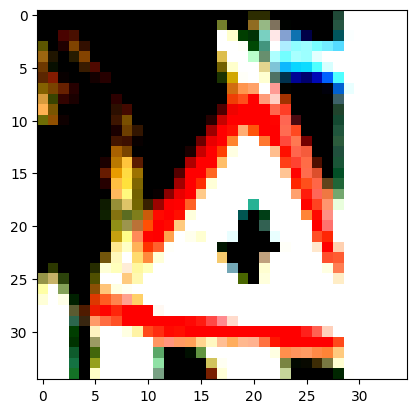

In [5]:
train_dataset = ImageFolder(root='GTSRB/Final_Training/Images', transform=transform)

test_dataset = ImageFolder(root='GTSRB/Final_Test/Images', transform=transform)

# Die Batchsize ist die Anzahl der Bilder, die auf einmal in das Netzwerk eingespeist werden. 
# Heißt es werden pro Trainingsschritt 64 Bilder durch das Netzwerk geschickt, dafür der Loss berechnet und dann für diesen Batch gemittelt, 
# anschließend werden die Parameter auf dem Durchschnittsgradienten aktualisiert.
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
num_classes = 43
# --------- Testing ---------
img, label = test_dataset[4000]
label_string = test_dataset.classes[label]
print("Label:", label_string)
plt.imshow(img.permute(1, 2, 0))
#print(img)


### Create the Model

TODO: Über IMG Size sprechen (die meisten nutzen 32x32)

In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)
        
        self.fc6 = nn.Linear(128, 512) 
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)  
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(p=0.5)  
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()

        self.fc9 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = out.reshape(out.size(0), -1)
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)

        out = self.fc9(out)

        return out

### Different CNN Model

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Erste Convolutional-Schicht mit SELU-Aktivierung und Batch Normalization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Zweite Convolutional-Schicht mit ReLU-Aktivierung und Batch Normalization
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)
        
        # Max-Pooling und zusätzliche Batch Normalization
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Dritte Convolutional-Schicht mit ReLU-Aktivierung und Batch Normalization
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.bn4 = nn.BatchNorm2d(64)
        
        # Zweites Max-Pooling und Dropout
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)
        
        # Flatten, um die Tensoren für die Dense-Schichten vorzubereiten
        self.flatten = nn.Flatten()
        
        # Dense-Schichten mit ReLU, Batch Normalization und Dropout
        self.fc1 = nn.Linear(64 * 7 * 7, 750)  # Anpassen der Eingangsgröße an die Architektur
        self.bn5 = nn.BatchNorm1d(750)
        self.dropout2 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(750, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.6)
        
        # Ausgabe-Schicht mit Softmax-Aktivierung
        self.fc3 = nn.Linear(256, 43)

    def forward(self, x):
        # Erste Convolutional-Schicht mit SELU
        x = F.selu(self.bn1(self.conv1(x)))
        
        # Zweite Convolutional-Schicht mit ReLU
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(self.bn3(x))
        
        # Dritte Convolutional-Schicht mit ReLU
        x = F.relu(self.bn4(self.conv3(x)))
        x = self.pool2(x)
        x = self.dropout1(x)
        
        # Flatten
        x = self.flatten(x)
        
        # Erste Dense-Schicht mit ReLU und Dropout
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout2(x)
        
        # Zweite Dense-Schicht mit ReLU und Dropout
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.dropout3(x)
        
        # Ausgabe-Schicht mit Softmax
        x = F.softmax(self.fc3(x), dim=1)
        return x


### Gans 🦢 viele CNNs trainieren 🏋️‍♀️🏋️‍♂️
Dropout von 0,2 bis 0,6  -> gleich lassen 0,5
Learing Rate von 0.001 bis 0.01 -> 0.01 0.005 0.001 
weight_decay von 0.0001 bis 0.005 -> 0.0001 0,0007 0,001 0,005
Factor 0.1 bis 0.9 -> gleich bei 0,9
Threshold 0.0001 bis 0.1 -> 0.1 0.01 0.001


In [7]:
# Initialisierung des Modells
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()

# Initiale Lernrate und Optimizer
lr = 0.01
weight_decay = 0.0001
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

# ReduceLROnPlateau Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.001)

### Train the model in a Loop

In [9]:
def training_loop(lr, weight_decay, threshold):
    # Initialisierung des Modells
    model = CNN(num_classes).to(device)
    loss_func = nn.CrossEntropyLoss()

    # Initiale Lernrate und Optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    # ReduceLROnPlateau Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=threshold, verbose=True)
    return model, loss_func, optimizer, scheduler

In [8]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Save model
torch.save(model.state_dict(), 'model/new_cnn_architecture.pth')

### Test model with accuracy print

Epoch 1/100
Training Loss: 3.7589
Training Accuracy: 16.96%
Test Accuracy: 14.61%
Learning Rate: [0.01]


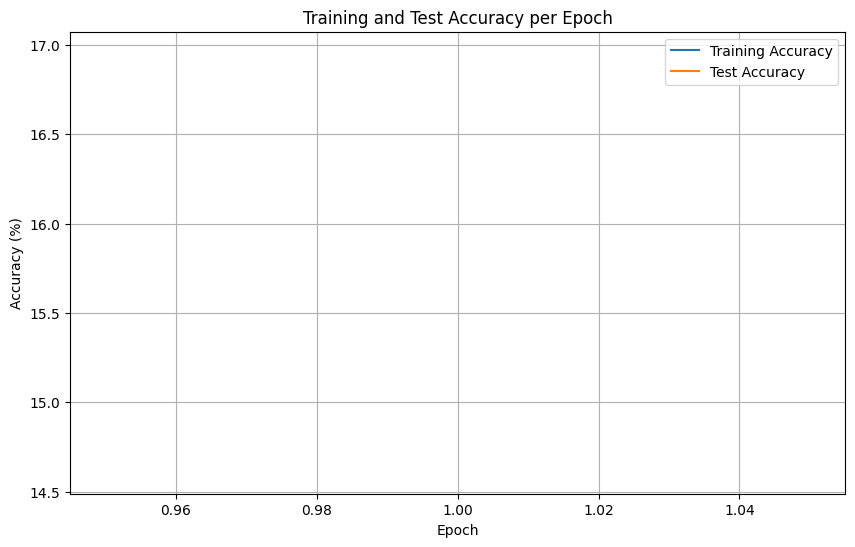

Epoch 2/100
Training Loss: 3.7353
Training Accuracy: 26.20%
Test Accuracy: 22.88%
Learning Rate: [0.01]


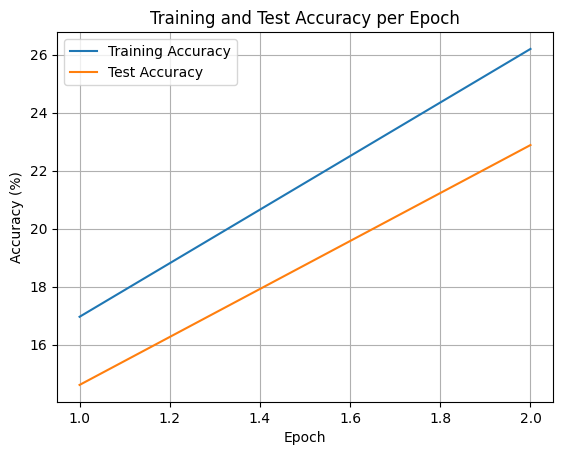

Epoch 3/100
Training Loss: 3.6677
Training Accuracy: 32.51%
Test Accuracy: 31.71%
Learning Rate: [0.01]


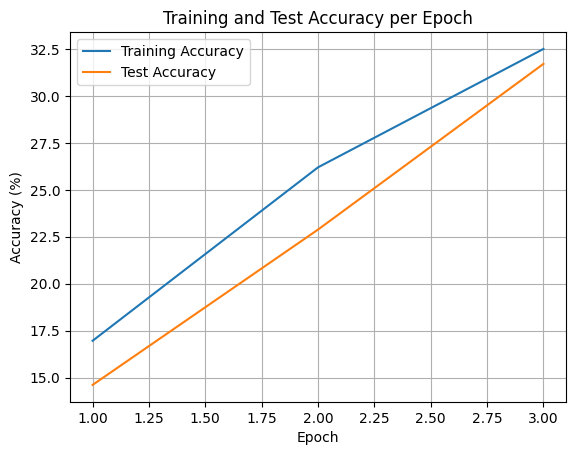

Epoch 4/100
Training Loss: 3.5694
Training Accuracy: 35.90%
Test Accuracy: 37.36%
Learning Rate: [0.01]


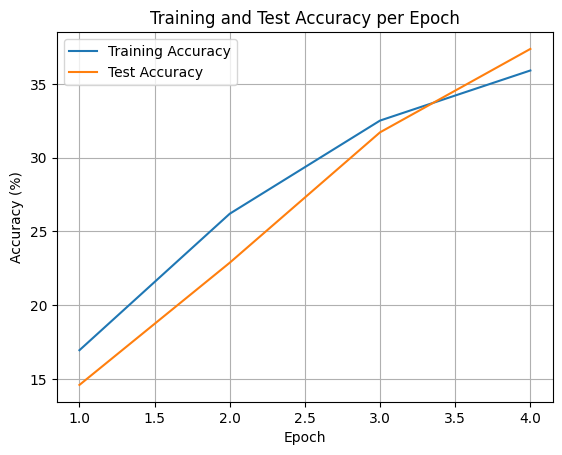

Epoch 5/100
Training Loss: 3.5108
Training Accuracy: 39.31%
Test Accuracy: 40.96%
Learning Rate: [0.01]


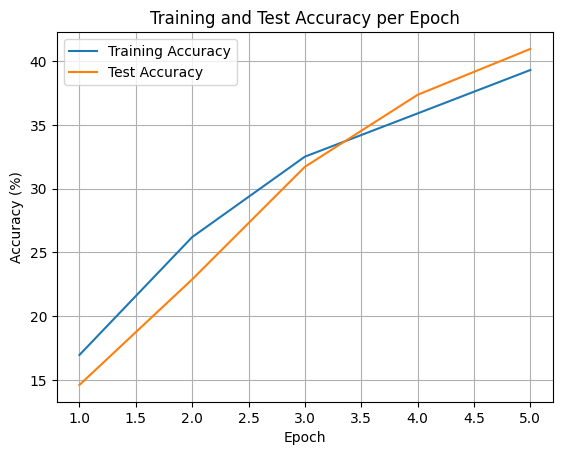

Epoch 6/100
Training Loss: 3.4674
Training Accuracy: 42.48%
Test Accuracy: 44.11%
Learning Rate: [0.01]


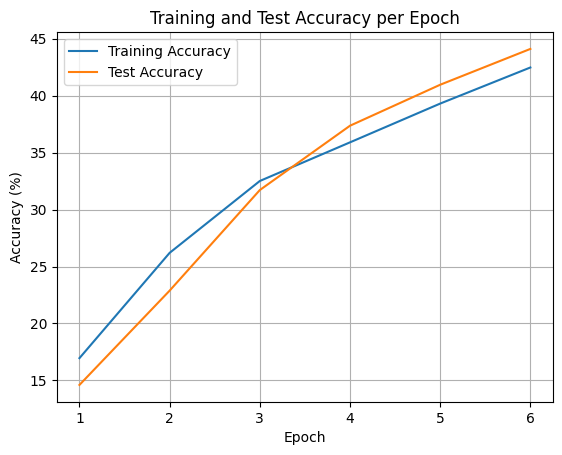

Epoch 7/100
Training Loss: 3.4310
Training Accuracy: 44.11%
Test Accuracy: 46.03%
Learning Rate: [0.01]


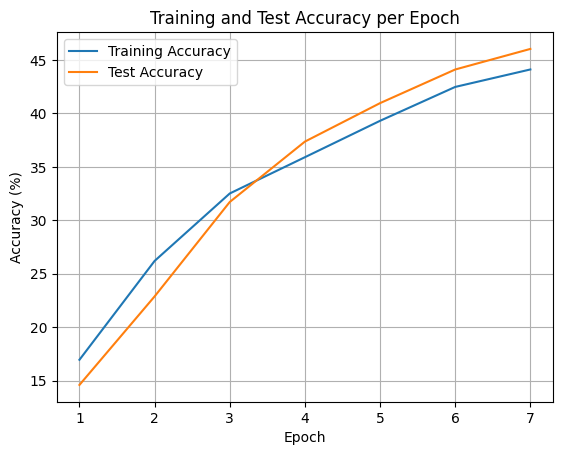

Epoch 8/100
Training Loss: 3.4007
Training Accuracy: 47.08%
Test Accuracy: 48.28%
Learning Rate: [0.01]


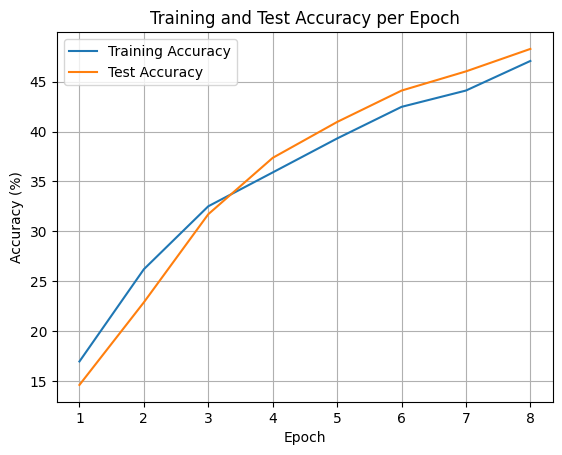

Epoch 9/100
Training Loss: 3.3691
Training Accuracy: 49.64%
Test Accuracy: 50.14%
Learning Rate: [0.01]


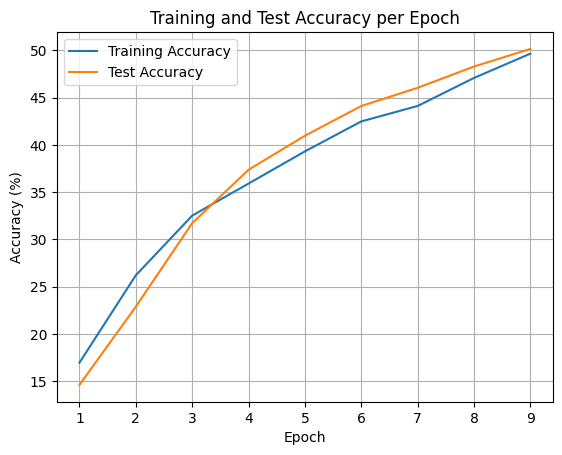

Epoch 10/100
Training Loss: 3.3352
Training Accuracy: 49.71%
Test Accuracy: 49.89%
Learning Rate: [0.01]


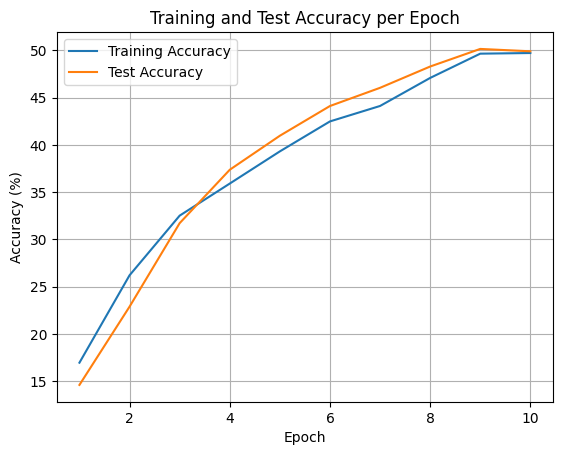

Epoch 11/100
Training Loss: 3.3228
Training Accuracy: 49.83%
Test Accuracy: 50.37%
Learning Rate: [0.01]


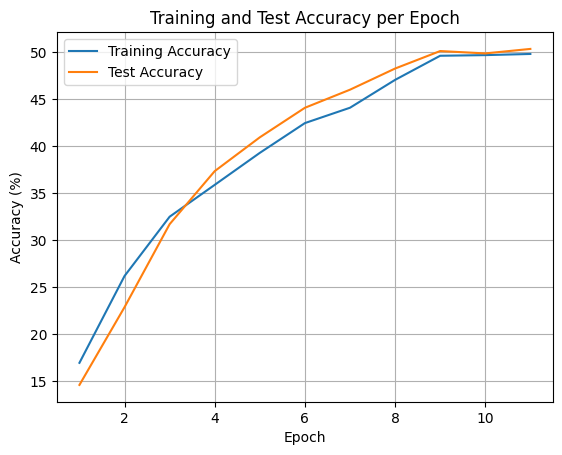

Epoch 12/100
Training Loss: 3.3162
Training Accuracy: 50.06%
Test Accuracy: 50.95%
Learning Rate: [0.01]


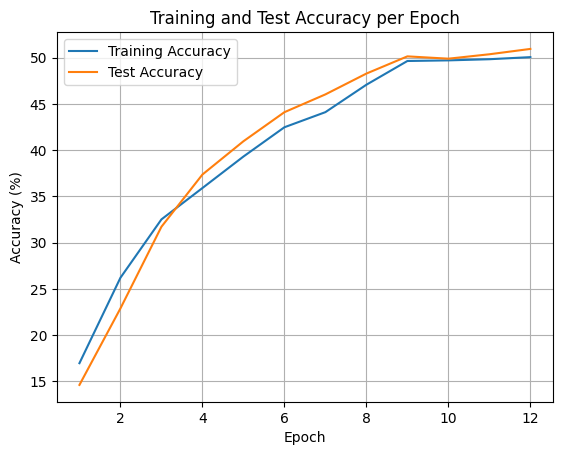

Epoch 13/100
Training Loss: 3.3088
Training Accuracy: 50.80%
Test Accuracy: 50.94%
Learning Rate: [0.01]


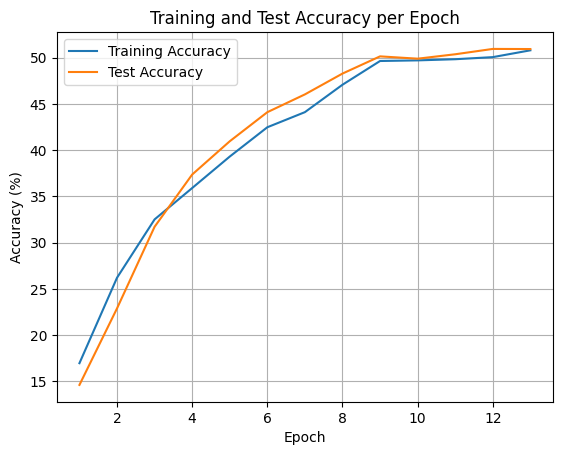

Epoch 14/100
Training Loss: 3.3015
Training Accuracy: 52.72%
Test Accuracy: 53.23%
Learning Rate: [0.01]


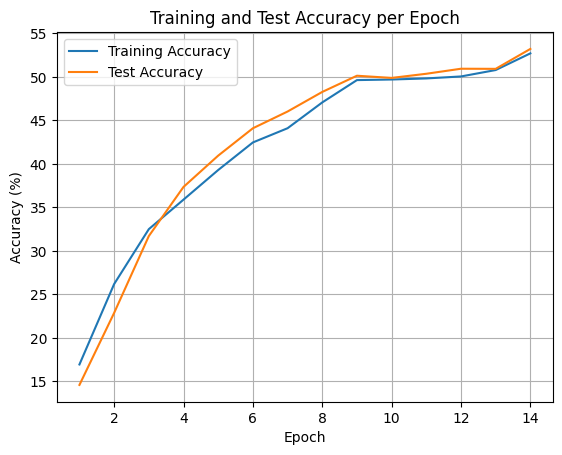

Epoch 15/100
Training Loss: 3.2883
Training Accuracy: 53.47%
Test Accuracy: 53.88%
Learning Rate: [0.01]


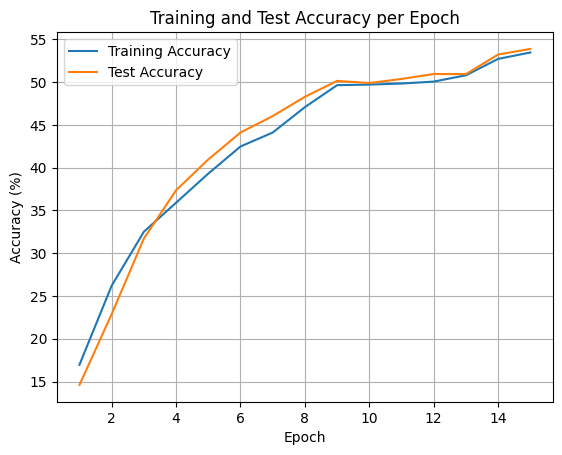

Epoch 16/100
Training Loss: 3.2814
Training Accuracy: 53.82%
Test Accuracy: 54.13%
Learning Rate: [0.01]


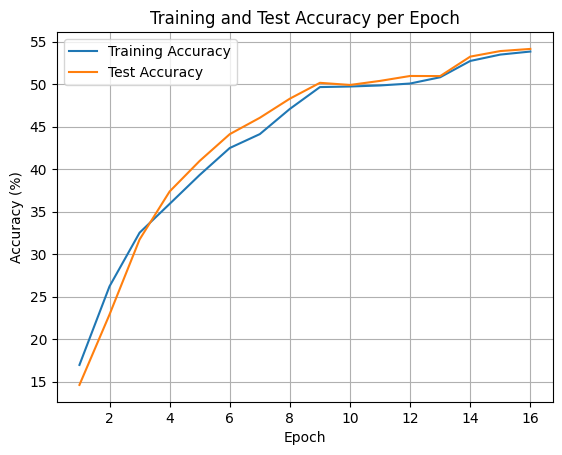

Epoch 17/100
Training Loss: 3.2765
Training Accuracy: 54.30%
Test Accuracy: 54.70%
Learning Rate: [0.01]


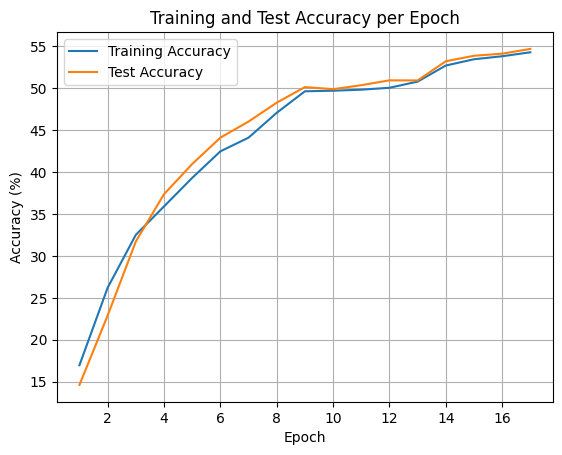

Epoch 18/100
Training Loss: 3.2720
Training Accuracy: 55.10%
Test Accuracy: 55.83%
Learning Rate: [0.01]


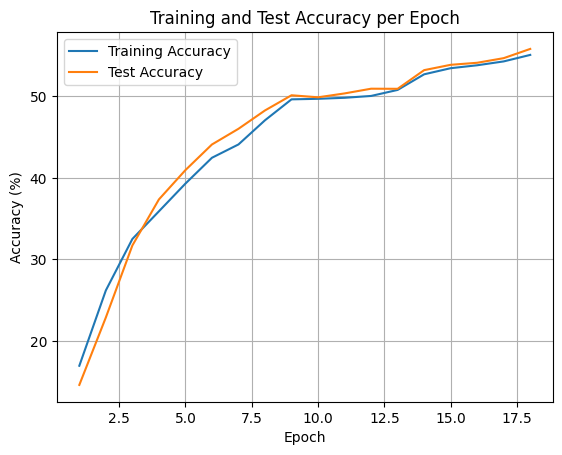

Epoch 19/100
Training Loss: 3.2689
Training Accuracy: 56.38%
Test Accuracy: 56.91%
Learning Rate: [0.01]


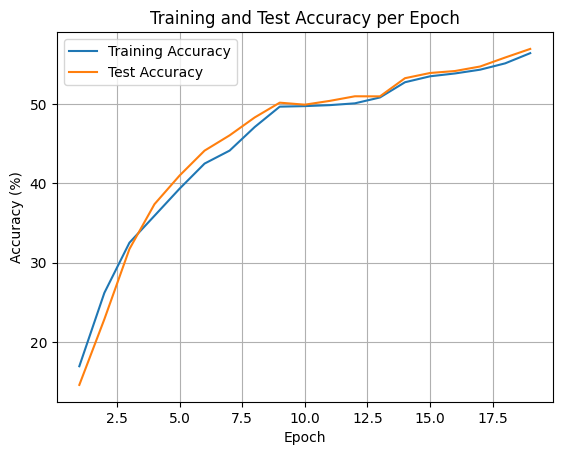

Epoch 20/100
Training Loss: 3.2634
Training Accuracy: 57.44%
Test Accuracy: 57.60%
Learning Rate: [0.01]


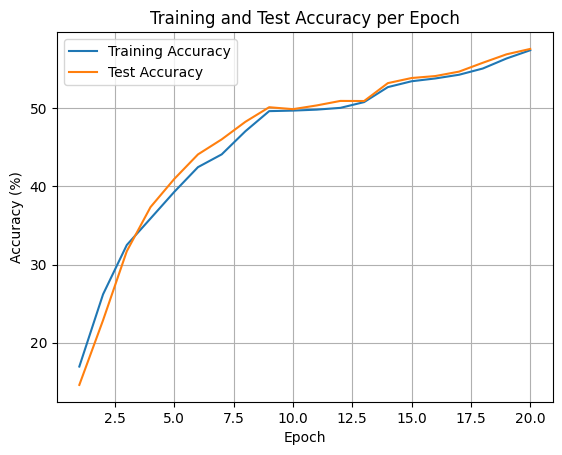

Epoch 21/100
Training Loss: 3.2538
Training Accuracy: 58.02%
Test Accuracy: 58.35%
Learning Rate: [0.01]


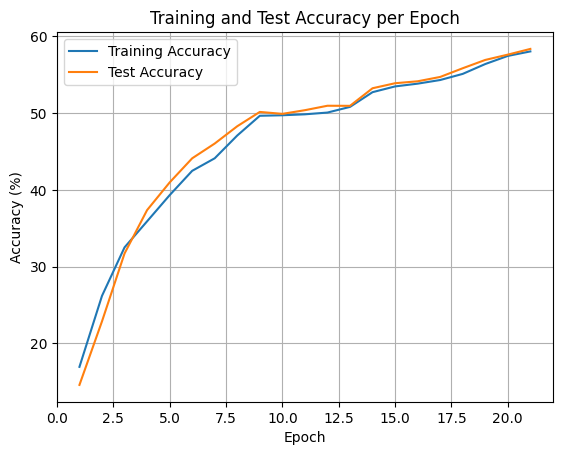

Epoch 22/100
Training Loss: 3.2405
Training Accuracy: 59.17%
Test Accuracy: 58.99%
Learning Rate: [0.01]


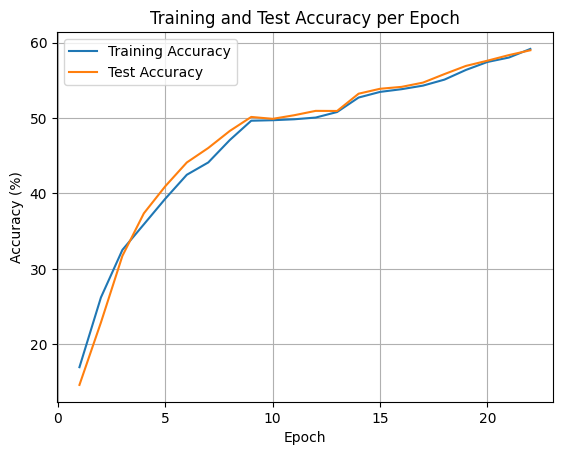

Epoch 23/100
Training Loss: 3.2273
Training Accuracy: 62.94%
Test Accuracy: 62.70%
Learning Rate: [0.01]


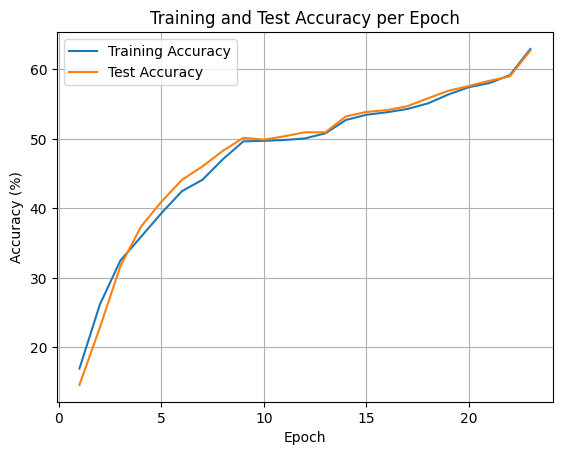

Epoch 24/100
Training Loss: 3.2008
Training Accuracy: 64.05%
Test Accuracy: 64.73%
Learning Rate: [0.01]


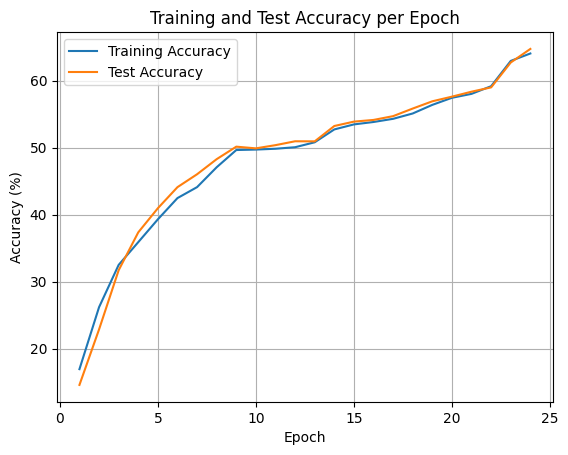

Epoch 25/100
Training Loss: 3.1861
Training Accuracy: 64.04%
Test Accuracy: 64.79%
Learning Rate: [0.01]


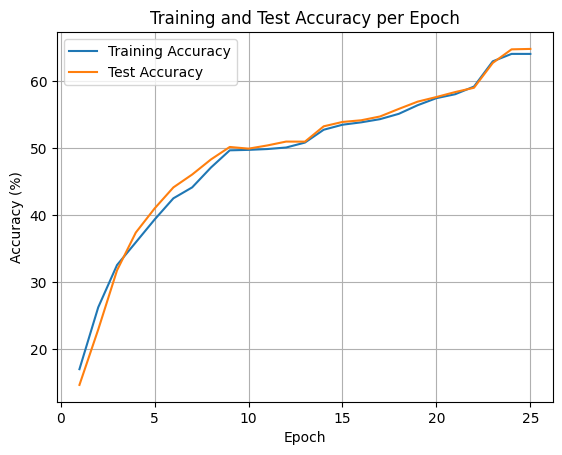

Epoch 26/100
Training Loss: 3.1789
Training Accuracy: 64.11%
Test Accuracy: 64.83%
Learning Rate: [0.01]


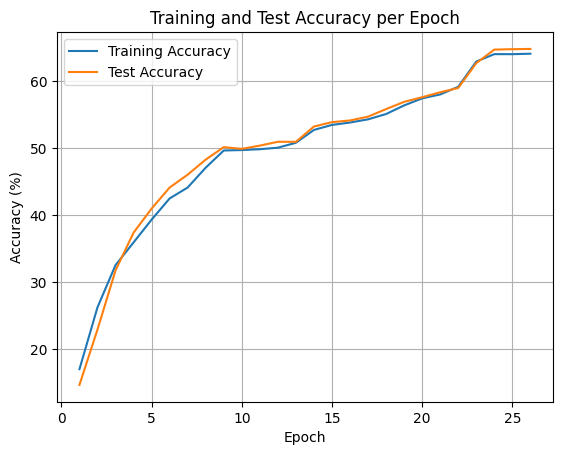

Epoch 27/100
Training Loss: 3.1747
Training Accuracy: 64.09%
Test Accuracy: 64.85%
Learning Rate: [0.01]


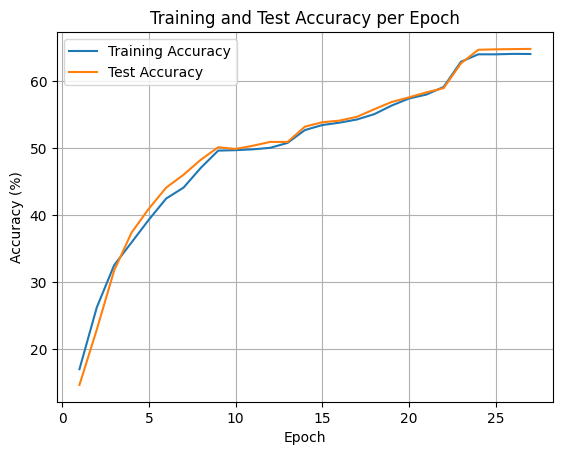

Epoch 28/100
Training Loss: 3.1726
Training Accuracy: 64.08%
Test Accuracy: 64.88%
Learning Rate: [0.01]


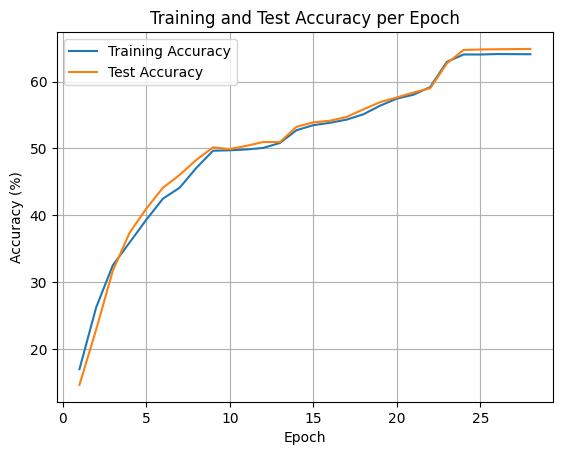

Epoch 29/100
Training Loss: 3.1707
Training Accuracy: 64.10%
Test Accuracy: 64.94%
Learning Rate: [0.01]


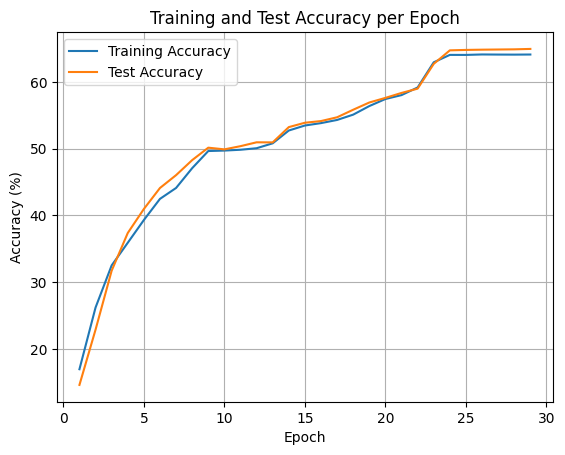

Epoch 30/100
Training Loss: 3.1689
Training Accuracy: 64.12%
Test Accuracy: 64.90%
Learning Rate: [0.01]


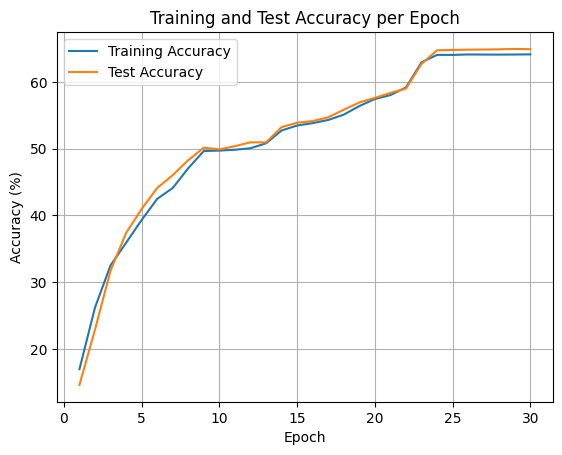

Epoch 31/100
Training Loss: 3.1677
Training Accuracy: 64.11%
Test Accuracy: 64.95%
Learning Rate: [0.01]


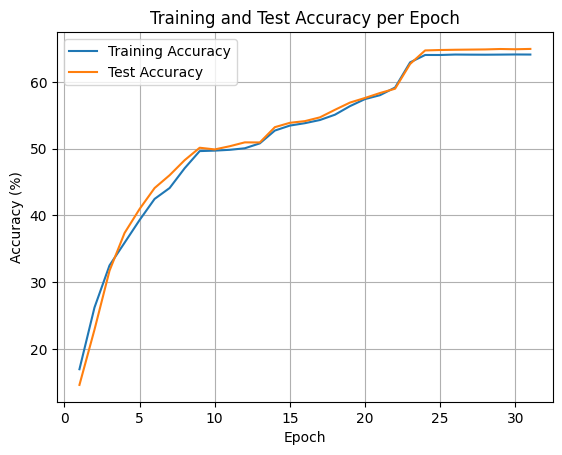

Epoch 32/100
Training Loss: 3.1666
Training Accuracy: 64.12%
Test Accuracy: 64.93%
Learning Rate: [0.01]


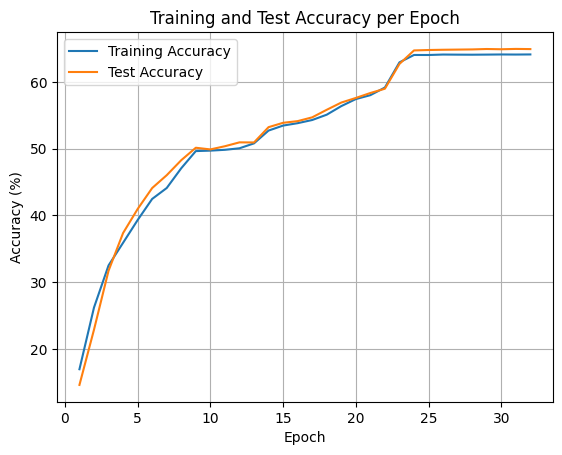

Epoch 33/100
Training Loss: 3.1651
Training Accuracy: 64.13%
Test Accuracy: 64.93%
Learning Rate: [0.01]


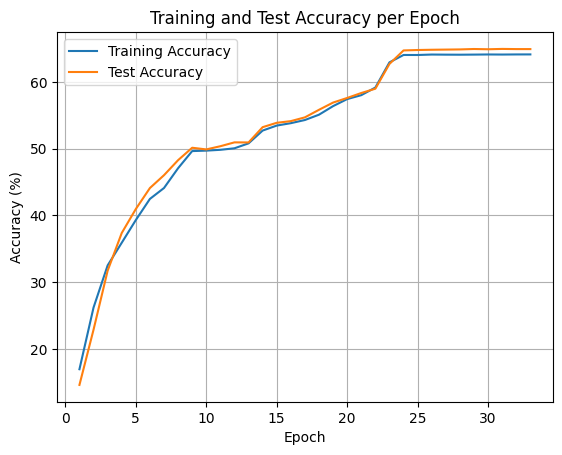

Epoch 34/100
Training Loss: 3.1634
Training Accuracy: 64.13%
Test Accuracy: 64.89%
Learning Rate: [0.01]


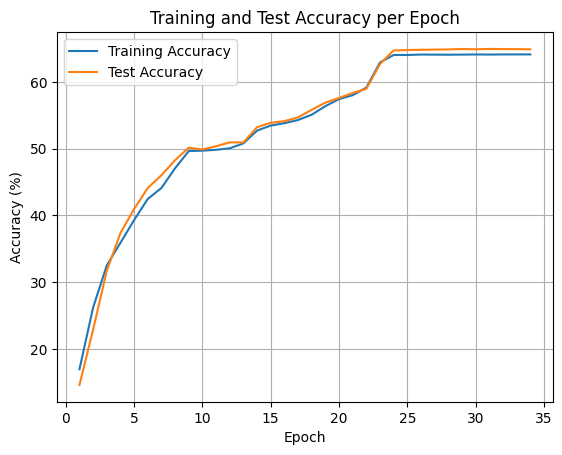

Epoch 35/100
Training Loss: 3.1630
Training Accuracy: 64.16%
Test Accuracy: 64.90%
Learning Rate: [0.01]


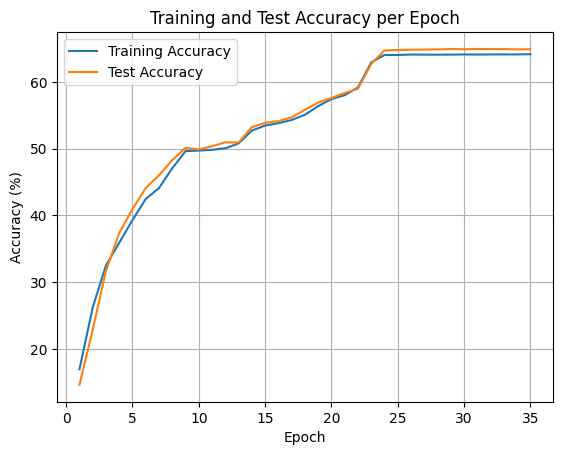

Epoch 36/100
Training Loss: 3.1625
Training Accuracy: 64.20%
Test Accuracy: 65.03%
Learning Rate: [0.01]


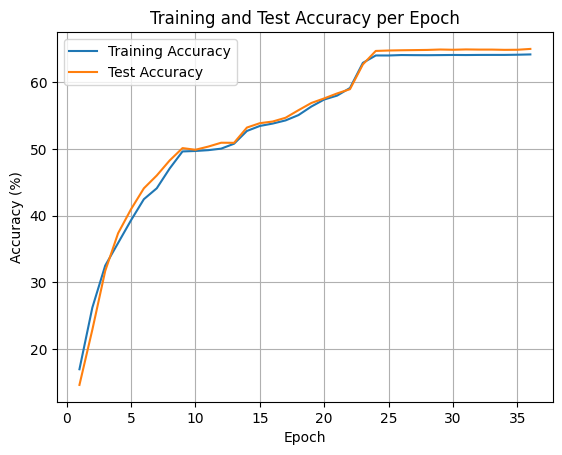

Epoch 37/100
Training Loss: 3.1616
Training Accuracy: 64.40%
Test Accuracy: 65.18%
Learning Rate: [0.01]


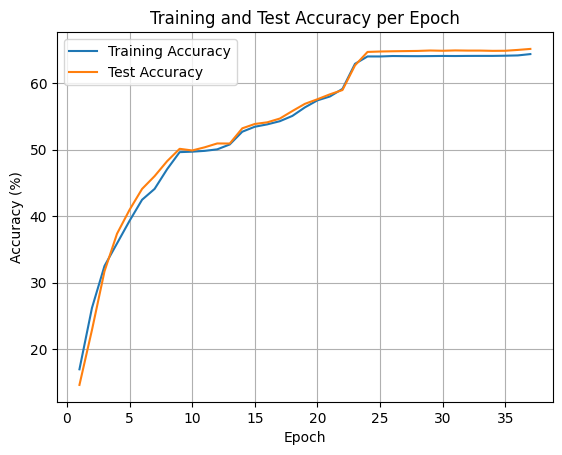

Epoch 38/100
Training Loss: 3.1607
Training Accuracy: 64.70%
Test Accuracy: 65.56%
Learning Rate: [0.01]


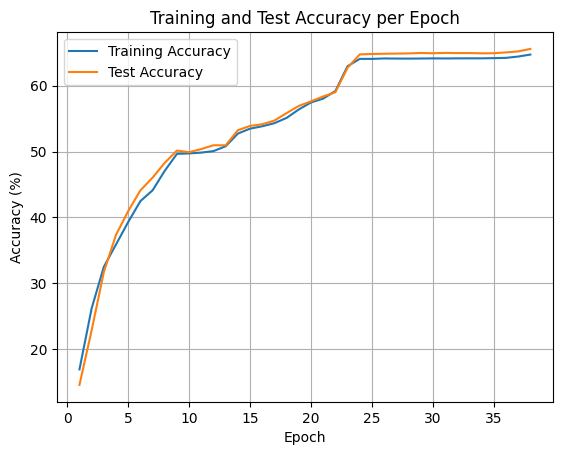

Epoch 39/100
Training Loss: 3.1590
Training Accuracy: 65.02%
Test Accuracy: 66.08%
Learning Rate: [0.005]


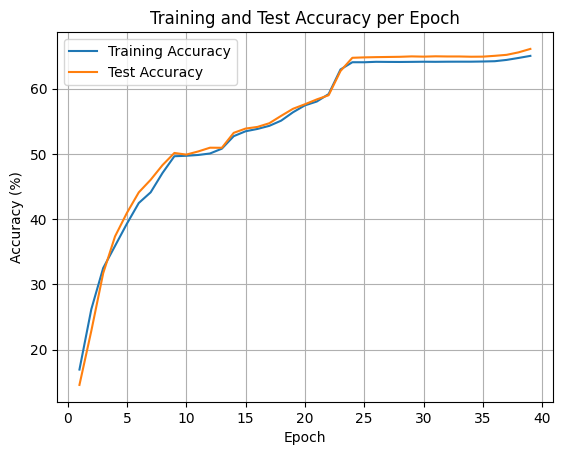

Epoch 40/100
Training Loss: 3.1579
Training Accuracy: 65.59%
Test Accuracy: 66.54%
Learning Rate: [0.005]


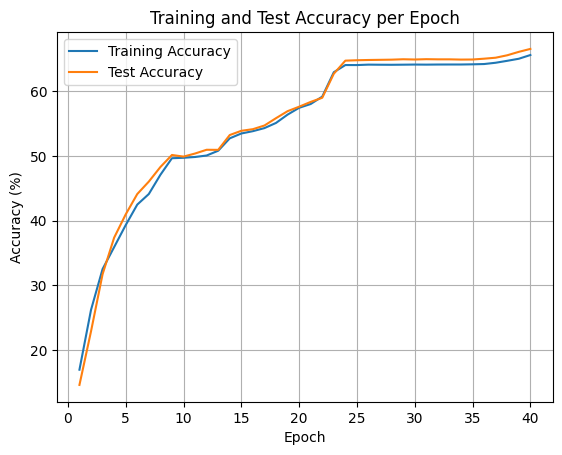

Epoch 41/100
Training Loss: 3.1573
Training Accuracy: 65.94%
Test Accuracy: 67.00%
Learning Rate: [0.005]


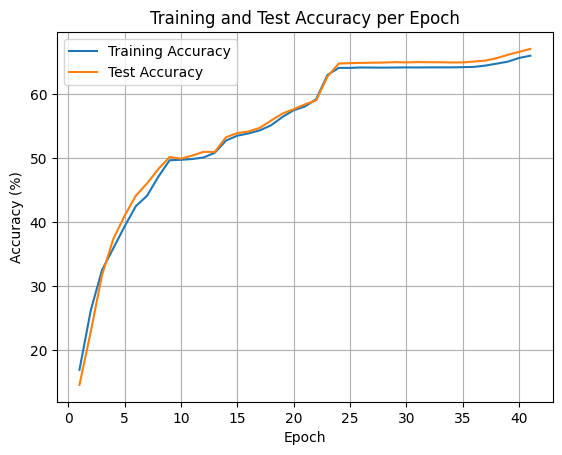

Epoch 42/100
Training Loss: 3.1558
Training Accuracy: 66.50%
Test Accuracy: 67.76%
Learning Rate: [0.005]


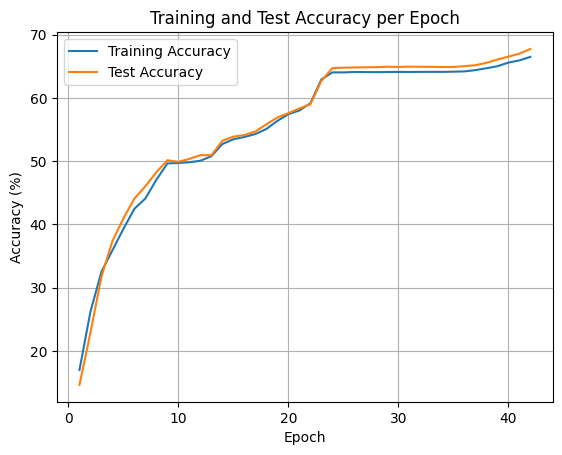

Epoch 43/100
Training Loss: 3.1519
Training Accuracy: 67.15%
Test Accuracy: 68.37%
Learning Rate: [0.005]


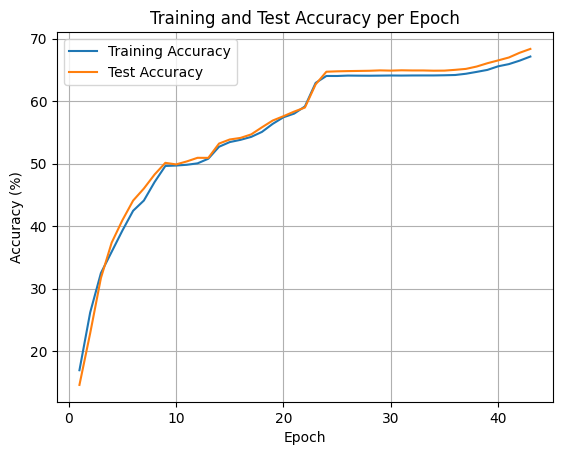

Epoch 44/100
Training Loss: 3.1462
Training Accuracy: 67.83%
Test Accuracy: 68.78%
Learning Rate: [0.005]


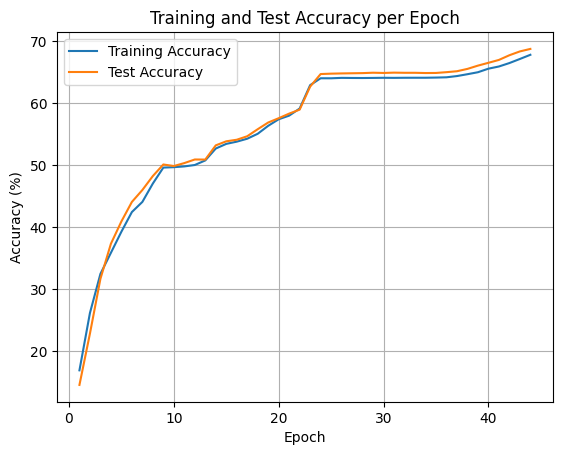

Epoch 45/100
Training Loss: 3.1412
Training Accuracy: 68.30%
Test Accuracy: 69.09%
Learning Rate: [0.005]


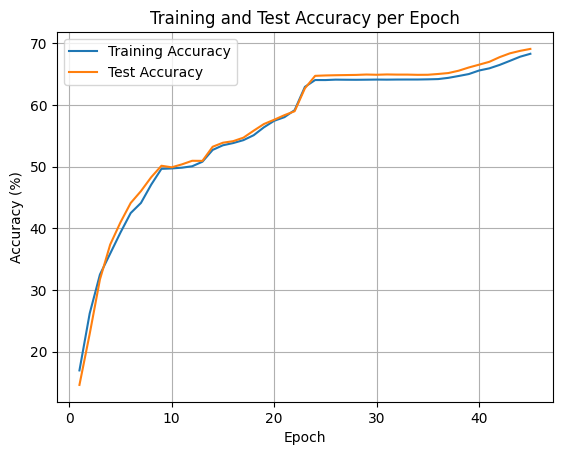

Epoch 46/100
Training Loss: 3.1369
Training Accuracy: 68.38%
Test Accuracy: 69.17%
Learning Rate: [0.005]


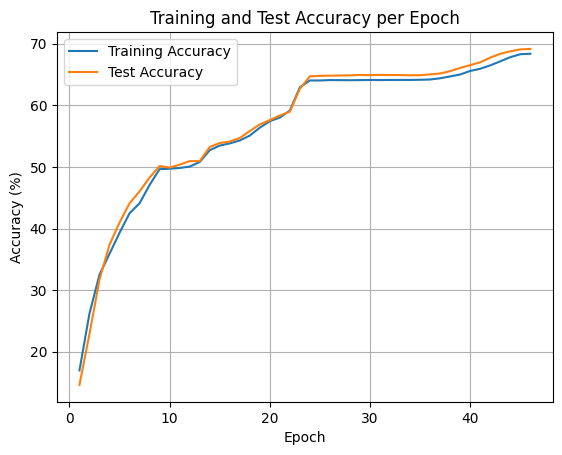

Epoch 47/100
Training Loss: 3.1331
Training Accuracy: 68.52%
Test Accuracy: 69.25%
Learning Rate: [0.005]


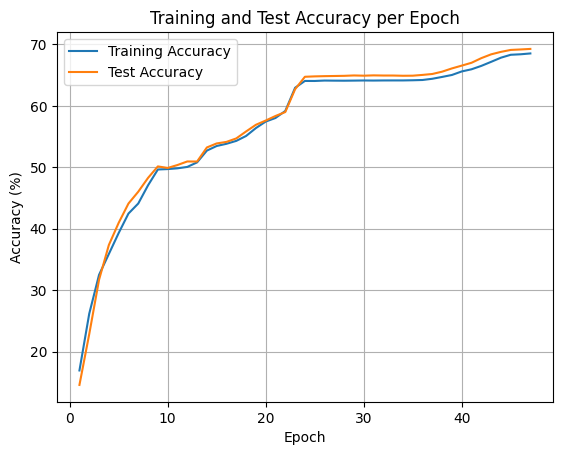

Epoch 48/100
Training Loss: 3.1315
Training Accuracy: 68.47%
Test Accuracy: 69.25%
Learning Rate: [0.005]


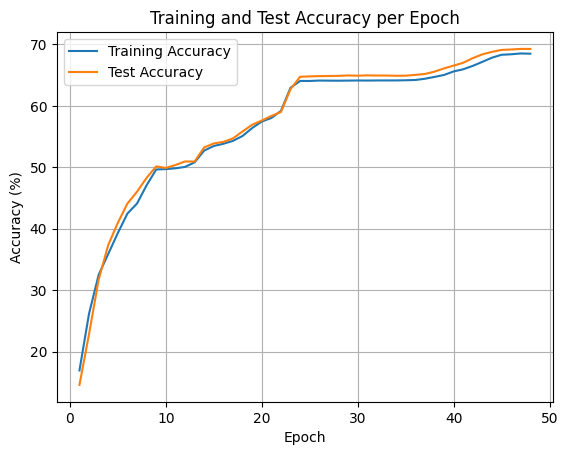

Epoch 49/100
Training Loss: 3.1299
Training Accuracy: 68.59%
Test Accuracy: 69.24%
Learning Rate: [0.005]


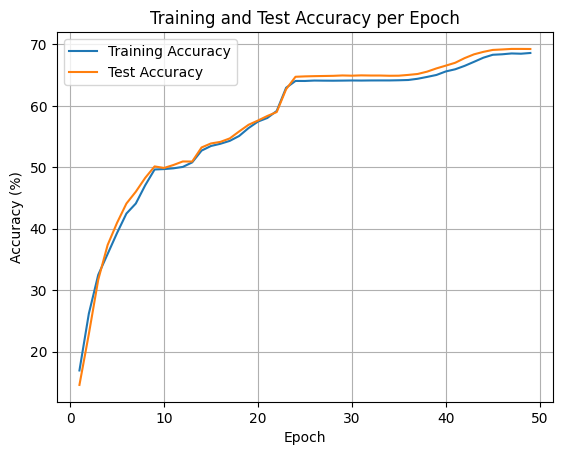

Epoch 50/100
Training Loss: 3.1283
Training Accuracy: 68.60%
Test Accuracy: 69.30%
Learning Rate: [0.005]


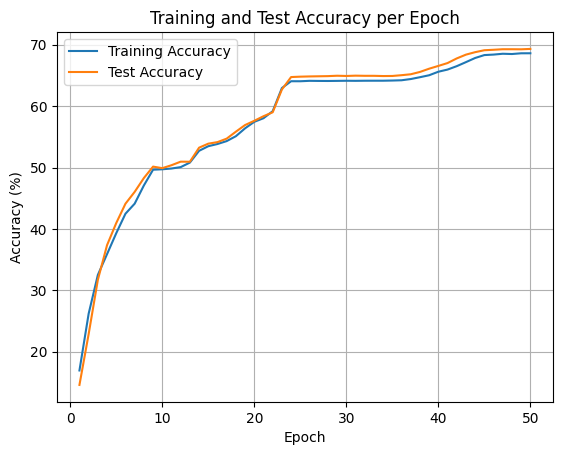

Epoch 51/100
Training Loss: 3.1275
Training Accuracy: 68.67%
Test Accuracy: 69.35%
Learning Rate: [0.005]


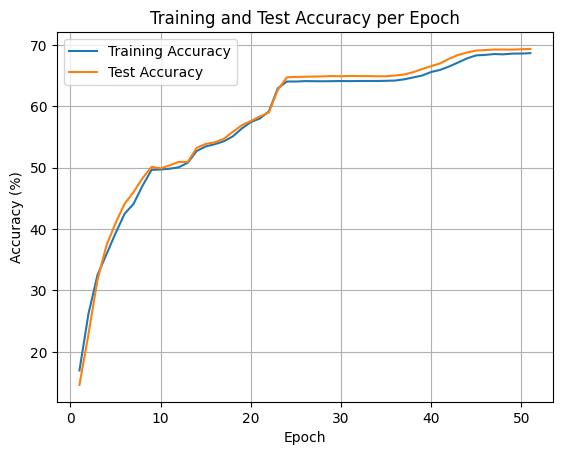

Epoch 52/100
Training Loss: 3.1263
Training Accuracy: 68.86%
Test Accuracy: 69.44%
Learning Rate: [0.005]


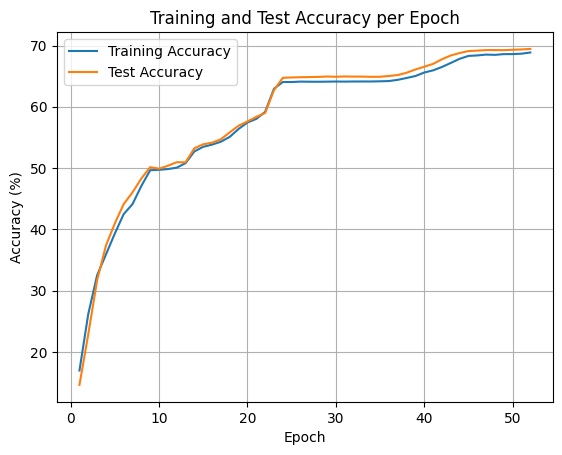

Epoch 53/100
Training Loss: 3.1248
Training Accuracy: 68.93%
Test Accuracy: 69.54%
Learning Rate: [0.005]


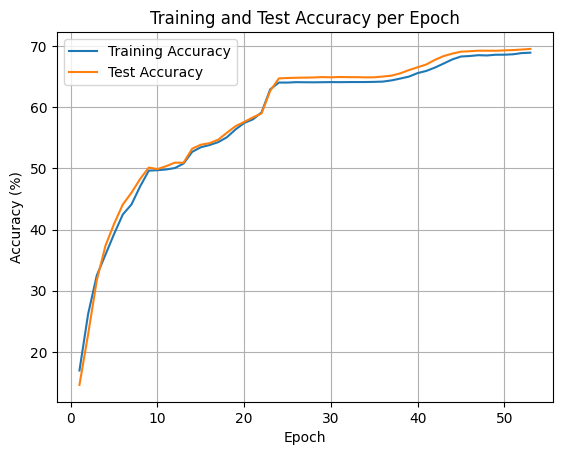

Epoch 54/100
Training Loss: 3.1238
Training Accuracy: 69.06%
Test Accuracy: 69.66%
Learning Rate: [0.005]


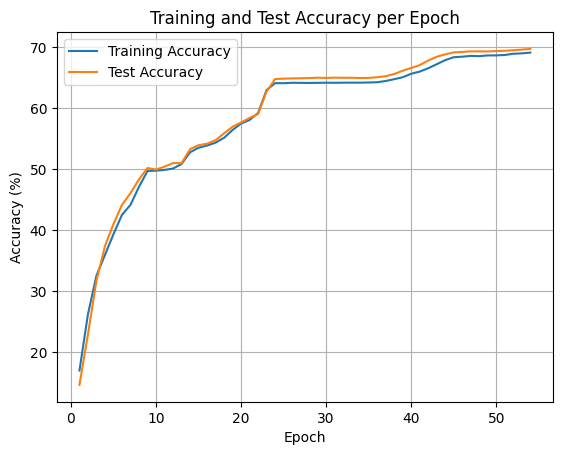

Epoch 55/100
Training Loss: 3.1227
Training Accuracy: 69.56%
Test Accuracy: 69.78%
Learning Rate: [0.005]


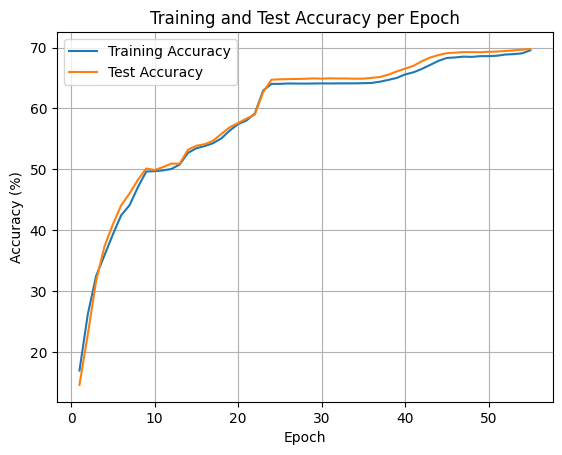

Epoch 56/100
Training Loss: 3.1222
Training Accuracy: 69.98%
Test Accuracy: 70.00%
Learning Rate: [0.005]


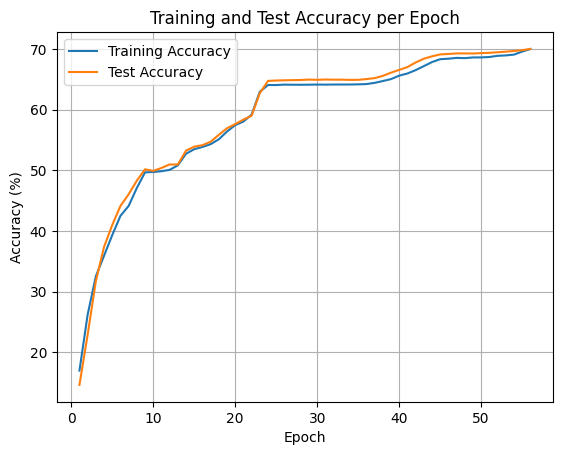

Epoch 57/100
Training Loss: 3.1206
Training Accuracy: 70.45%
Test Accuracy: 70.07%
Learning Rate: [0.005]


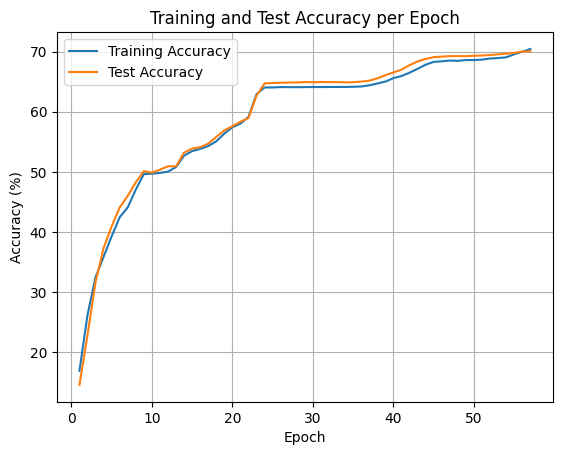

Epoch 58/100
Training Loss: 3.1177
Training Accuracy: 70.59%
Test Accuracy: 69.88%
Learning Rate: [0.005]


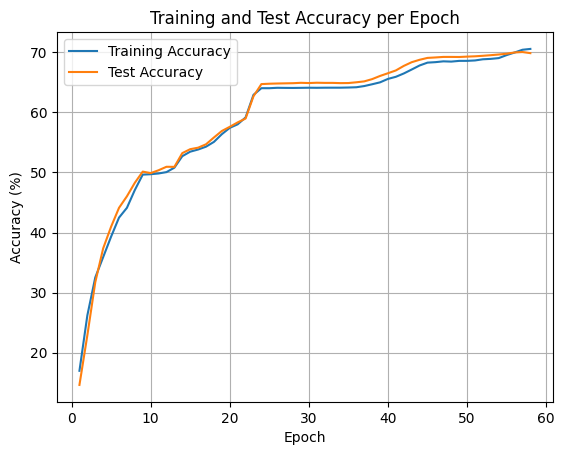

Epoch 59/100
Training Loss: 3.1122
Training Accuracy: 70.81%
Test Accuracy: 70.18%
Learning Rate: [0.005]


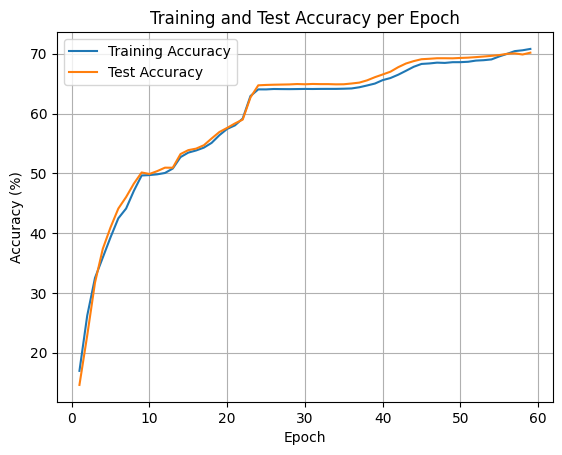

Epoch 60/100
Training Loss: 3.1082
Training Accuracy: 70.86%
Test Accuracy: 70.39%
Learning Rate: [0.005]


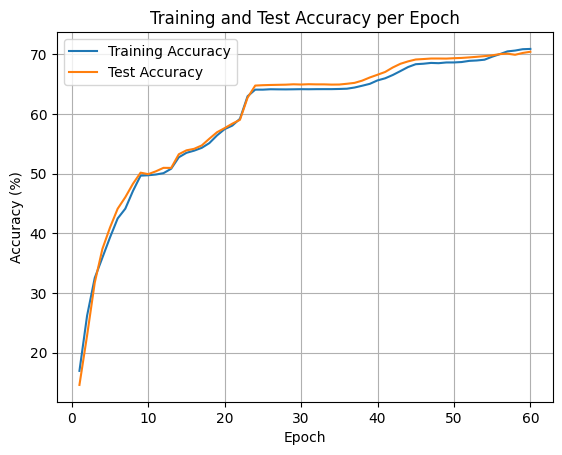

Epoch 61/100
Training Loss: 3.1061
Training Accuracy: 70.81%
Test Accuracy: 70.37%
Learning Rate: [0.005]


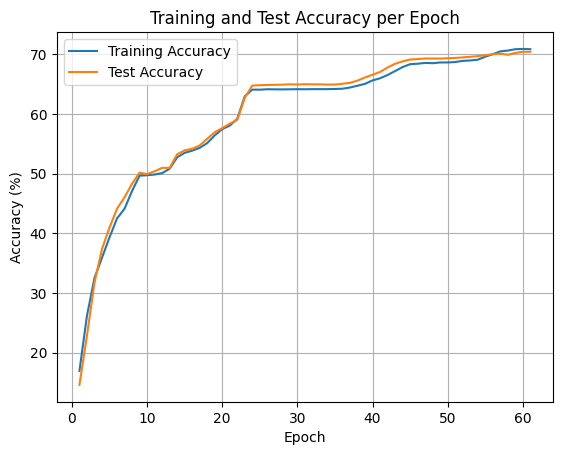

Epoch 62/100
Training Loss: 3.1045
Training Accuracy: 70.94%
Test Accuracy: 70.49%
Learning Rate: [0.005]


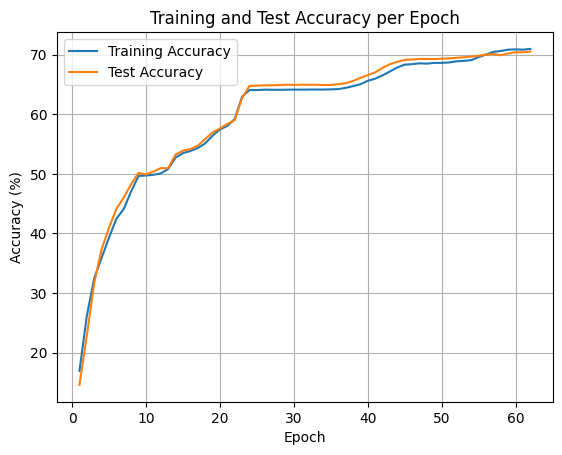

Epoch 63/100
Training Loss: 3.1039
Training Accuracy: 71.04%
Test Accuracy: 70.46%
Learning Rate: [0.005]


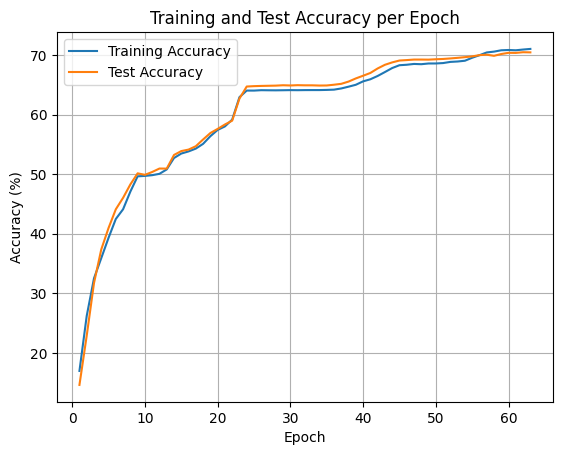

Epoch 64/100
Training Loss: 3.1033
Training Accuracy: 71.20%
Test Accuracy: 70.73%
Learning Rate: [0.005]


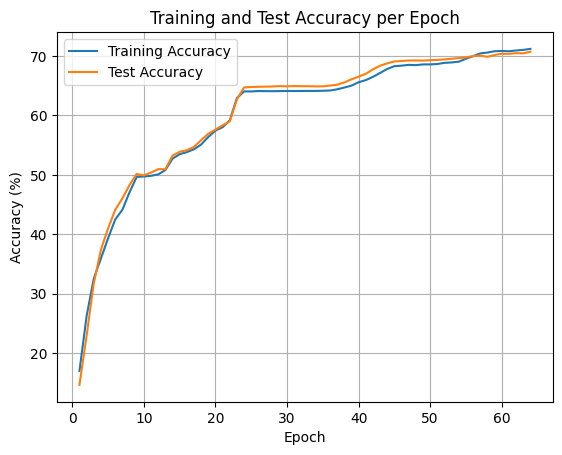

Epoch 65/100
Training Loss: 3.1017
Training Accuracy: 71.32%
Test Accuracy: 70.84%
Learning Rate: [0.005]


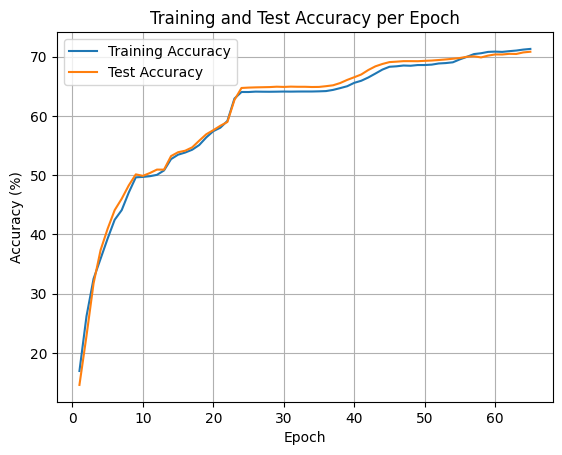

Epoch 66/100
Training Loss: 3.1011
Training Accuracy: 71.46%
Test Accuracy: 70.73%
Learning Rate: [0.005]


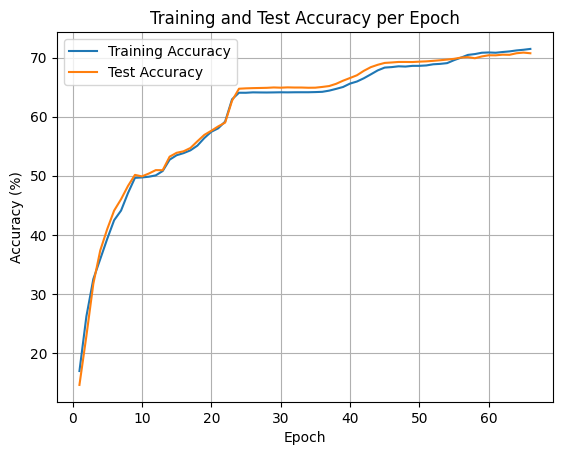

Epoch 67/100
Training Loss: 3.1005
Training Accuracy: 71.65%
Test Accuracy: 70.96%
Learning Rate: [0.005]


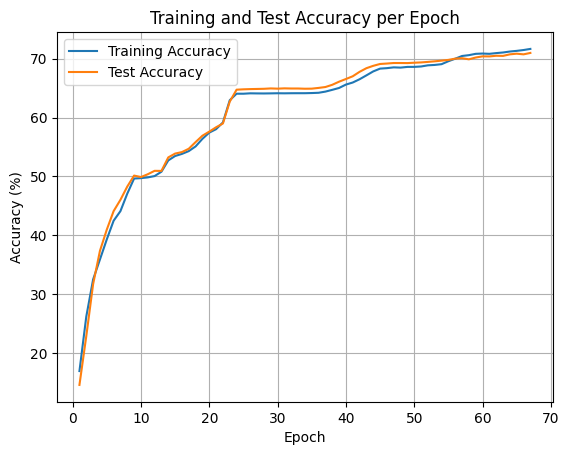

Epoch 68/100
Training Loss: 3.1001
Training Accuracy: 71.95%
Test Accuracy: 71.17%
Learning Rate: [0.005]


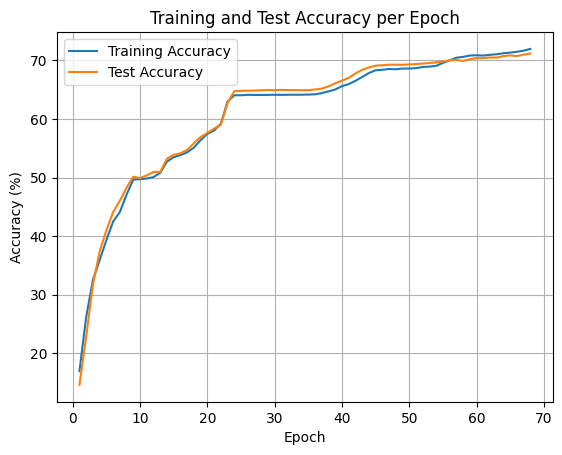

Epoch 69/100
Training Loss: 3.0995
Training Accuracy: 72.18%
Test Accuracy: 71.23%
Learning Rate: [0.005]


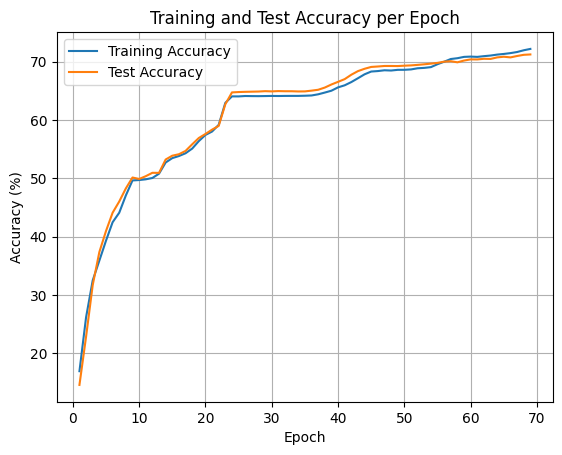

Epoch 70/100
Training Loss: 3.0985
Training Accuracy: 72.38%
Test Accuracy: 71.49%
Learning Rate: [0.005]


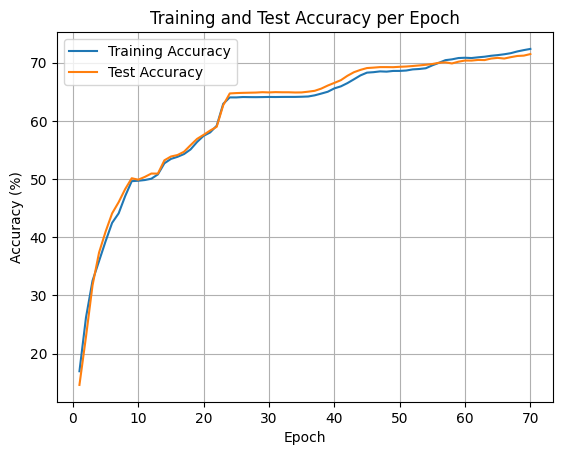

Epoch 71/100
Training Loss: 3.0971
Training Accuracy: 72.51%
Test Accuracy: 71.76%
Learning Rate: [0.0025]


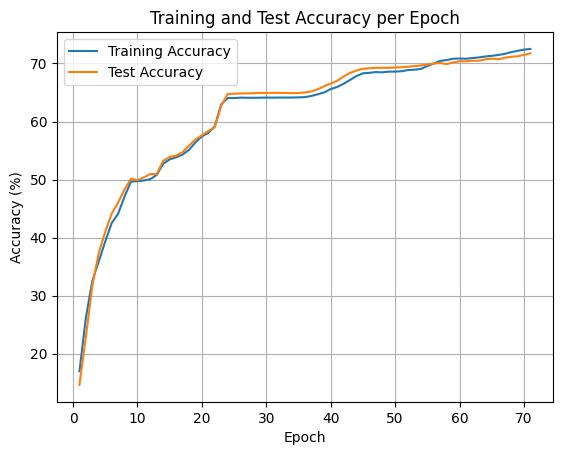

Epoch 72/100
Training Loss: 3.0959
Training Accuracy: 72.57%
Test Accuracy: 71.83%
Learning Rate: [0.0025]


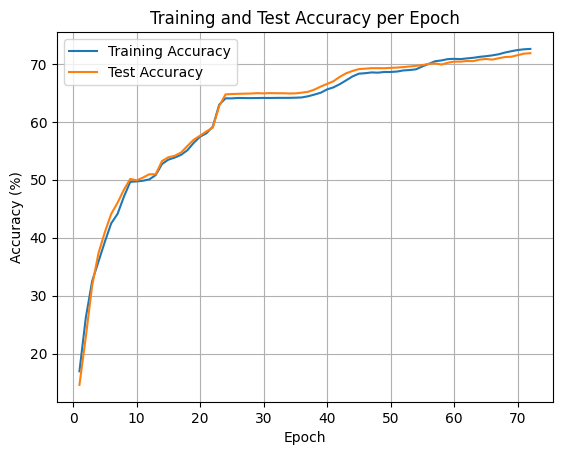

Epoch 73/100
Training Loss: 3.0945
Training Accuracy: 72.61%
Test Accuracy: 71.87%
Learning Rate: [0.0025]


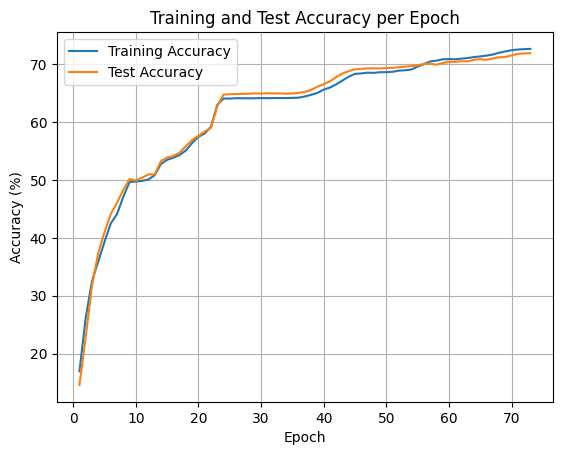

Epoch 74/100
Training Loss: 3.0934
Training Accuracy: 72.64%
Test Accuracy: 71.93%
Learning Rate: [0.0025]


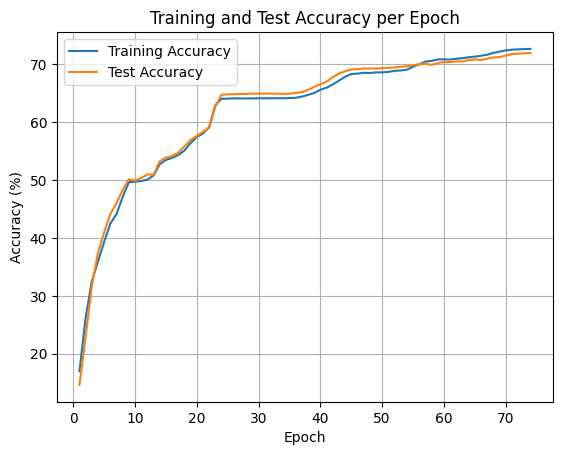

Epoch 75/100
Training Loss: 3.0902
Training Accuracy: 72.66%
Test Accuracy: 71.96%
Learning Rate: [0.0025]


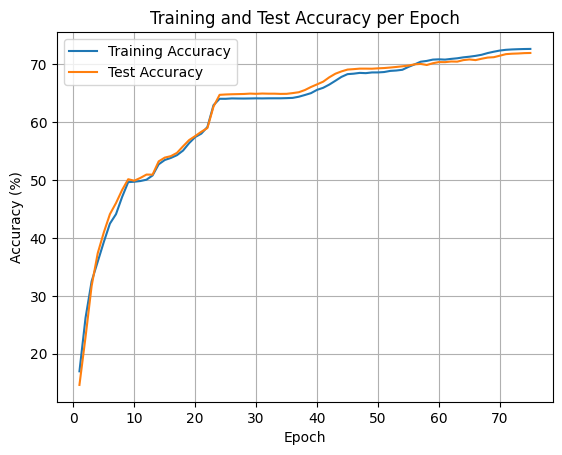

Epoch 76/100
Training Loss: 3.0887
Training Accuracy: 72.66%
Test Accuracy: 71.98%
Learning Rate: [0.0025]


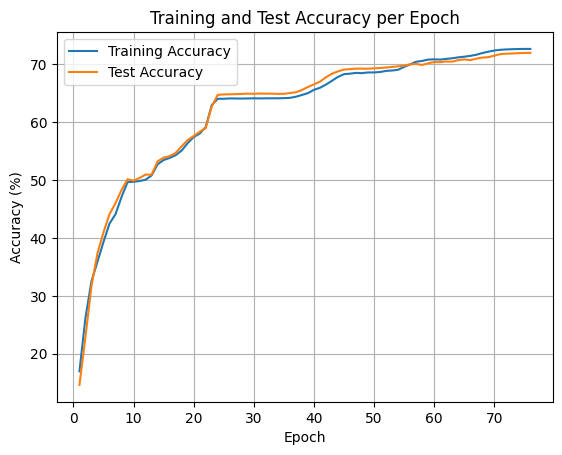

Epoch 77/100
Training Loss: 3.0872
Training Accuracy: 72.66%
Test Accuracy: 71.98%
Learning Rate: [0.0025]


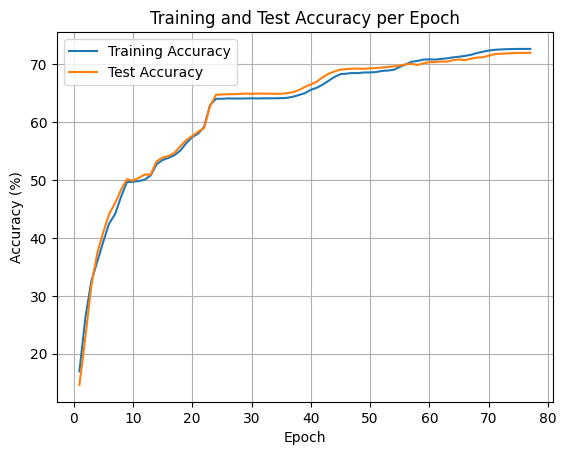

Epoch 78/100
Training Loss: 3.0852
Training Accuracy: 72.67%
Test Accuracy: 71.88%
Learning Rate: [0.0025]


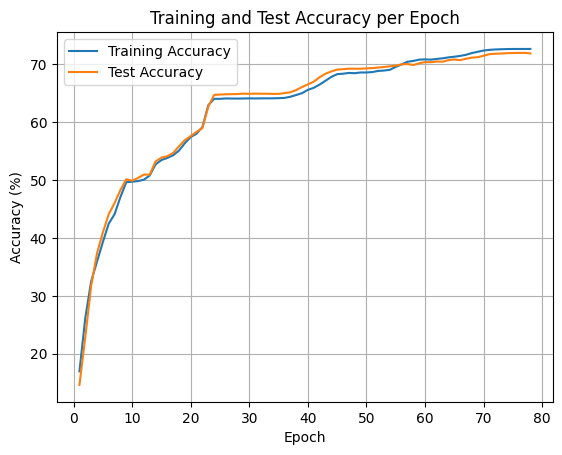

Epoch 79/100
Training Loss: 3.0843
Training Accuracy: 72.67%
Test Accuracy: 71.96%
Learning Rate: [0.0025]


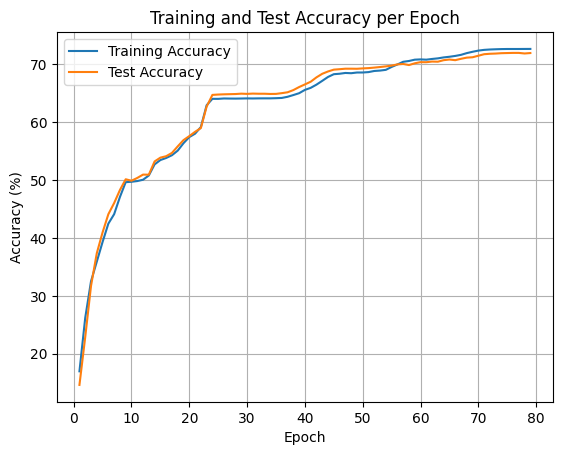

Epoch 80/100
Training Loss: 3.0842
Training Accuracy: 72.66%
Test Accuracy: 71.92%
Learning Rate: [0.0025]


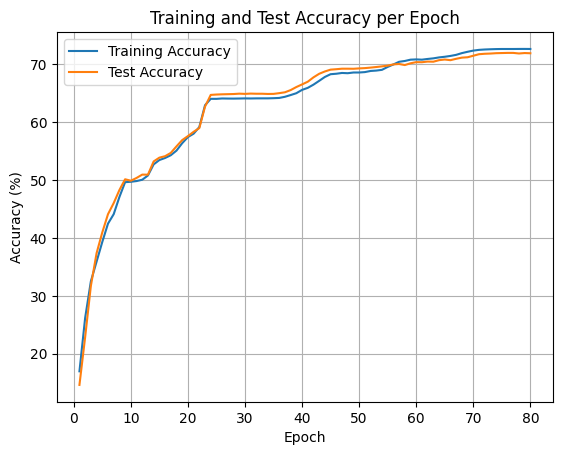

Epoch 81/100
Training Loss: 3.0836
Training Accuracy: 72.66%
Test Accuracy: 71.87%
Learning Rate: [0.0025]


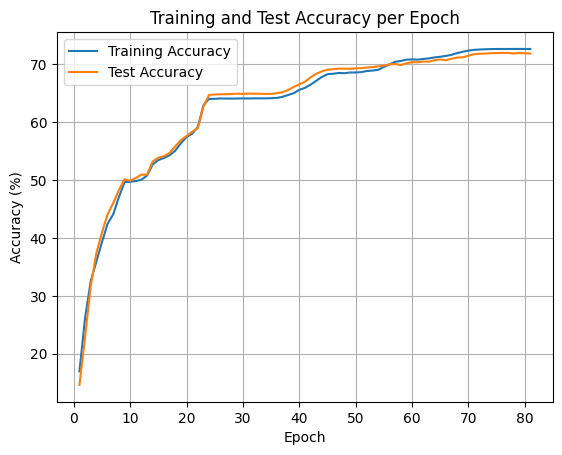

Epoch 82/100
Training Loss: 3.0832
Training Accuracy: 72.67%
Test Accuracy: 71.91%
Learning Rate: [0.0025]


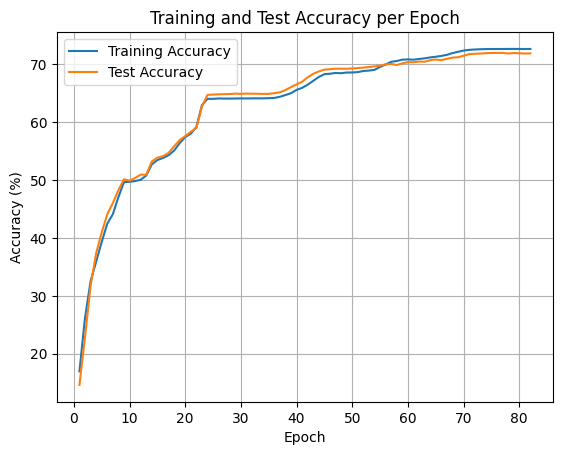

Epoch 83/100
Training Loss: 3.0827
Training Accuracy: 72.66%
Test Accuracy: 71.91%
Learning Rate: [0.00125]


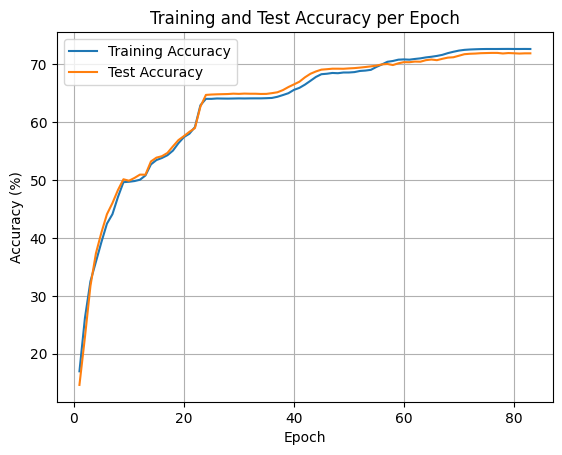

Epoch 84/100
Training Loss: 3.0817
Training Accuracy: 72.66%
Test Accuracy: 71.92%
Learning Rate: [0.00125]


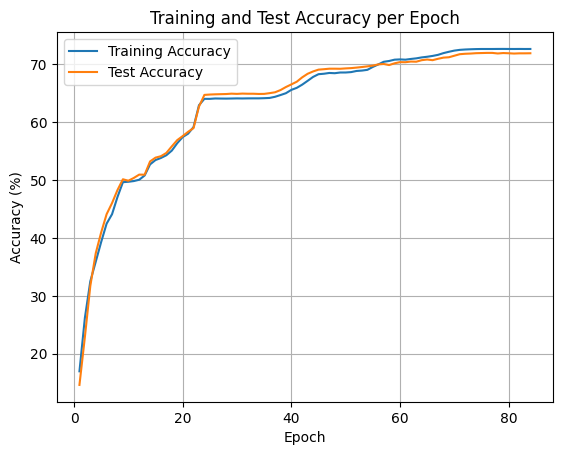

Epoch 85/100
Training Loss: 3.0813
Training Accuracy: 72.67%
Test Accuracy: 71.87%
Learning Rate: [0.00125]


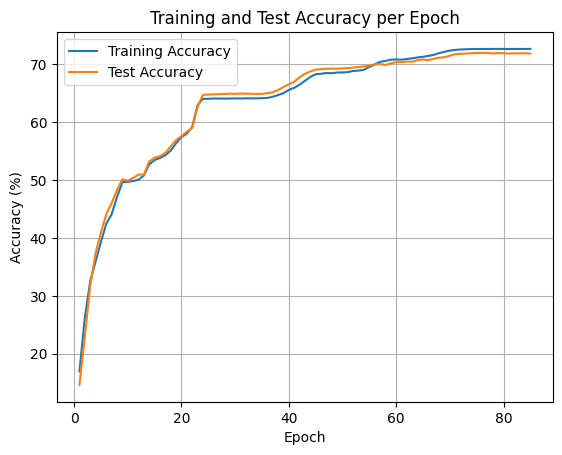

Epoch 86/100
Training Loss: 3.0814
Training Accuracy: 72.67%
Test Accuracy: 71.87%
Learning Rate: [0.00125]


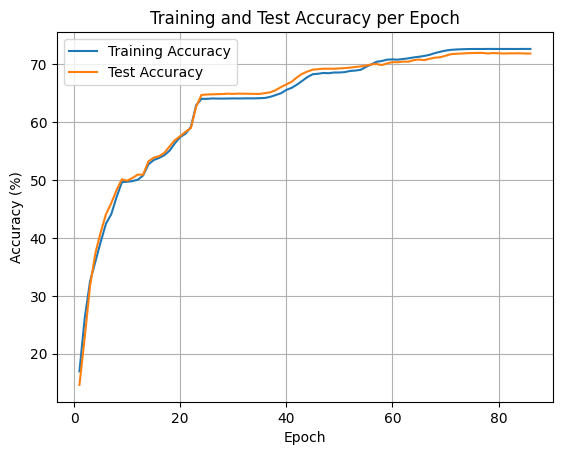

Epoch 87/100
Training Loss: 3.0818
Training Accuracy: 72.66%
Test Accuracy: 71.88%
Learning Rate: [0.00125]


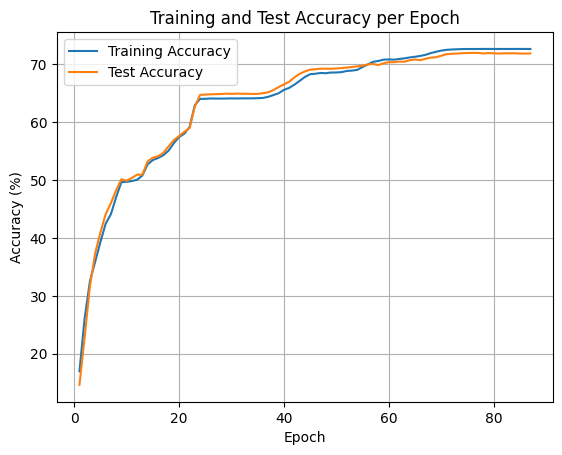

Epoch 88/100
Training Loss: 3.0815
Training Accuracy: 72.66%
Test Accuracy: 71.88%
Learning Rate: [0.00125]


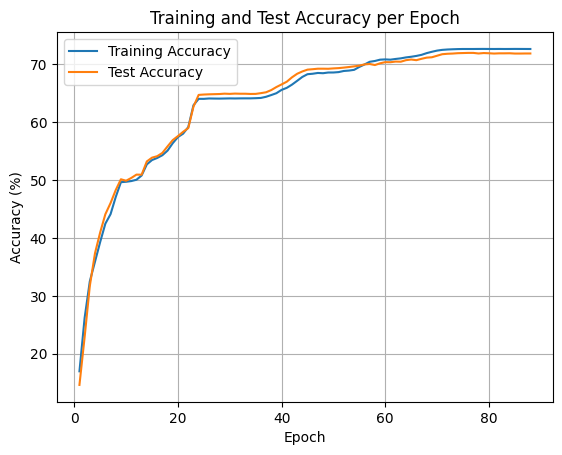

Epoch 89/100
Training Loss: 3.0815
Training Accuracy: 72.67%
Test Accuracy: 71.91%
Learning Rate: [0.000625]


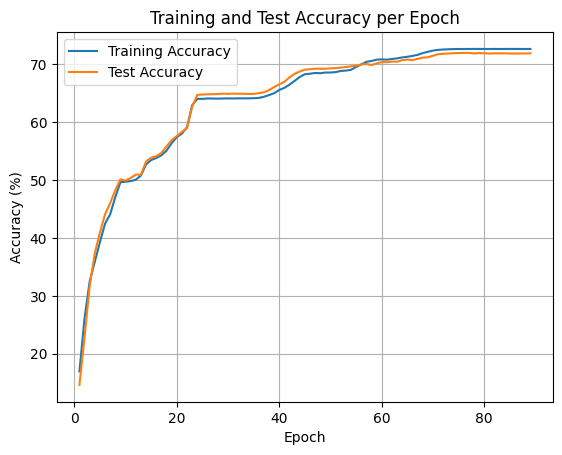

Epoch 90/100
Training Loss: 3.0810
Training Accuracy: 72.67%
Test Accuracy: 71.92%
Learning Rate: [0.000625]


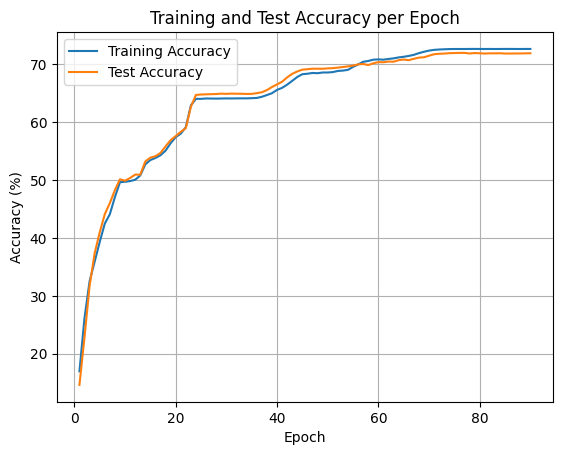

Epoch 91/100
Training Loss: 3.0807
Training Accuracy: 72.68%
Test Accuracy: 71.90%
Learning Rate: [0.000625]


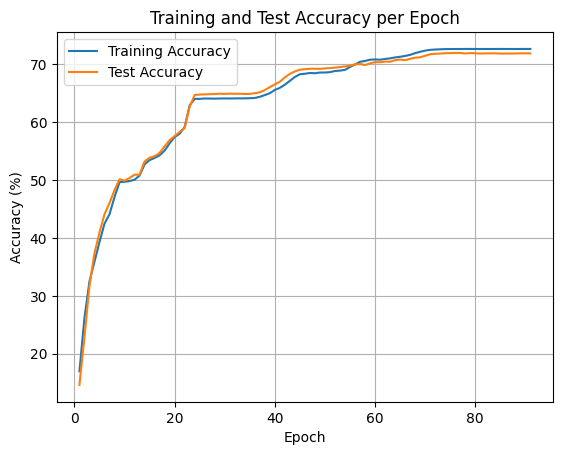

Epoch 92/100
Training Loss: 3.0805
Training Accuracy: 72.68%
Test Accuracy: 71.86%
Learning Rate: [0.000625]


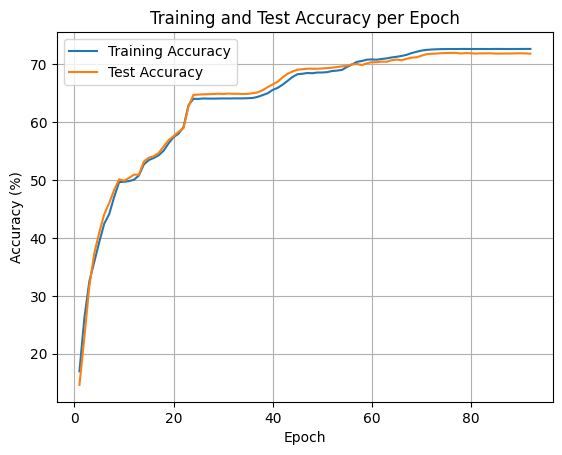

Epoch 93/100
Training Loss: 3.0811
Training Accuracy: 72.68%
Test Accuracy: 71.88%
Learning Rate: [0.0003125]


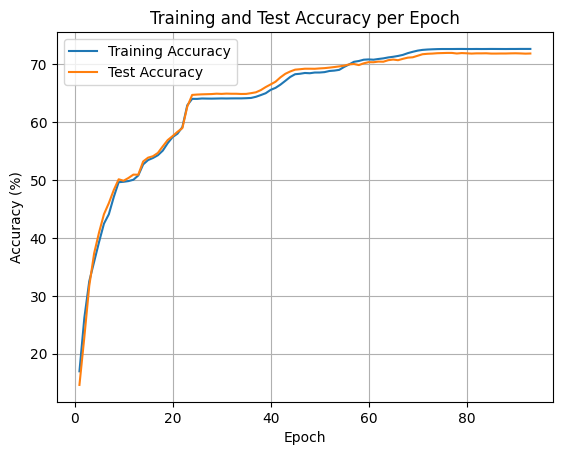

Epoch 94/100
Training Loss: 3.0805
Training Accuracy: 72.66%
Test Accuracy: 71.86%
Learning Rate: [0.0003125]


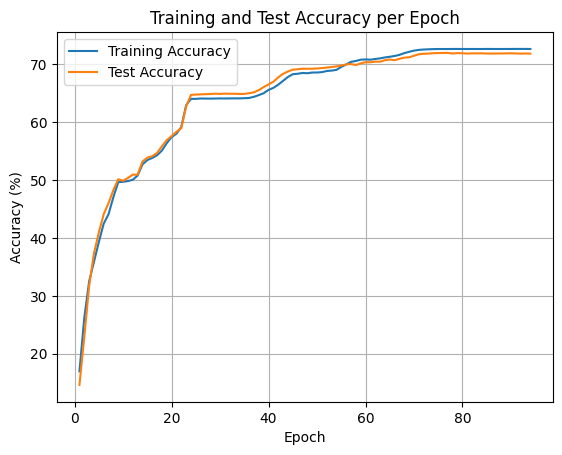

Epoch 95/100
Training Loss: 3.0807
Training Accuracy: 72.68%
Test Accuracy: 71.88%
Learning Rate: [0.0003125]


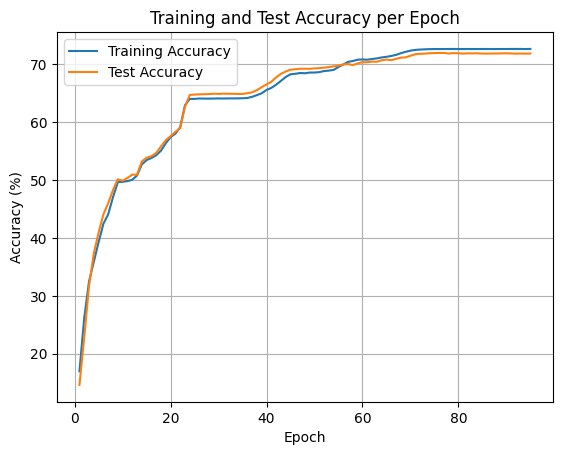

Epoch 96/100
Training Loss: 3.0799
Training Accuracy: 72.67%
Test Accuracy: 71.88%
Learning Rate: [0.0003125]


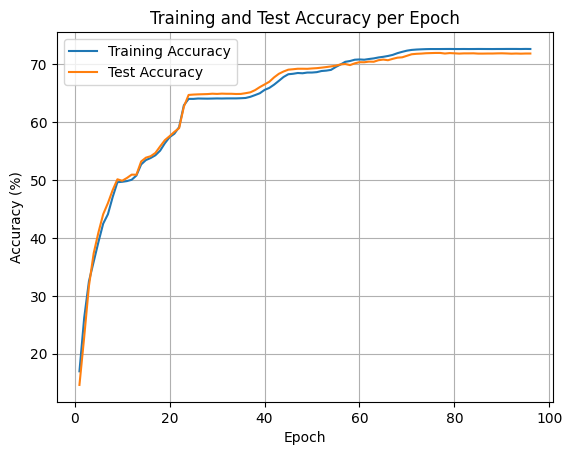

Epoch 97/100
Training Loss: 3.0801
Training Accuracy: 72.68%
Test Accuracy: 71.88%
Learning Rate: [0.00015625]


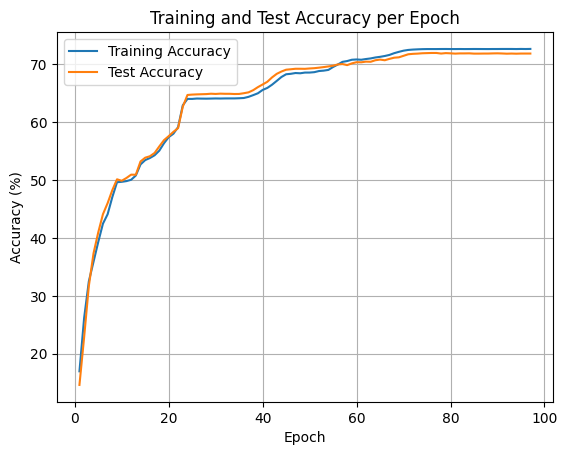

Epoch 98/100
Training Loss: 3.0807
Training Accuracy: 72.68%
Test Accuracy: 71.91%
Learning Rate: [0.00015625]


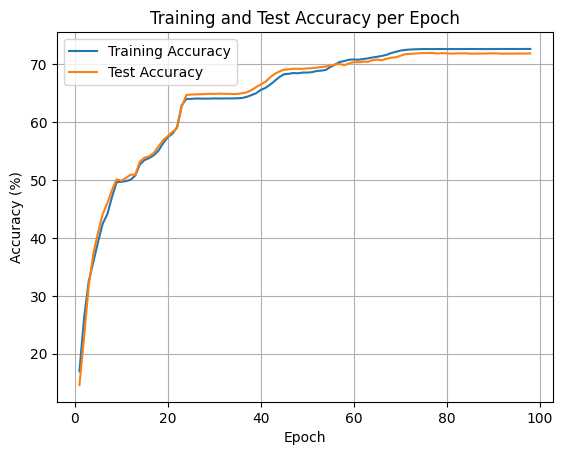

Epoch 99/100
Training Loss: 3.0802
Training Accuracy: 72.68%
Test Accuracy: 71.86%
Learning Rate: [0.00015625]


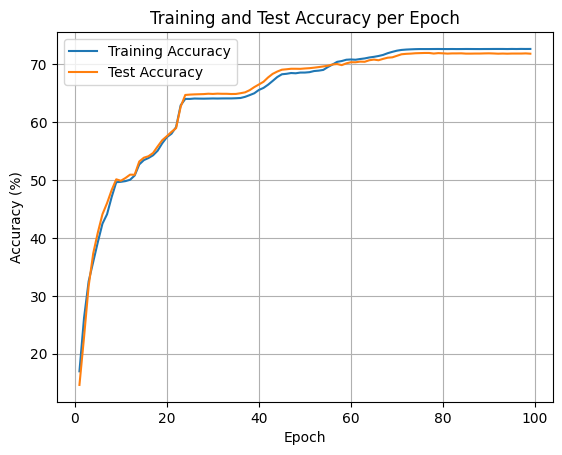

Epoch 100/100
Training Loss: 3.0806
Training Accuracy: 72.67%
Test Accuracy: 71.86%
Learning Rate: [0.00015625]


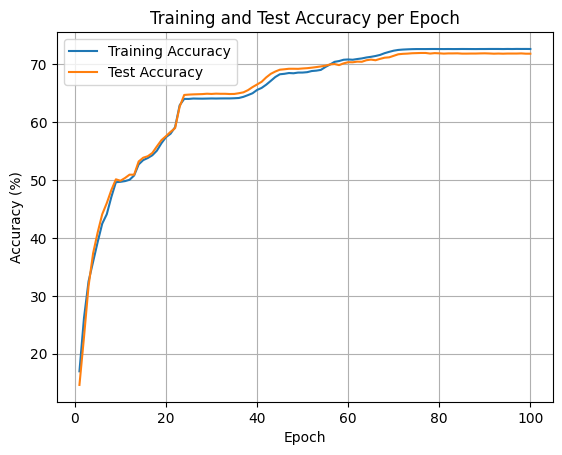

In [9]:
num_epochs = 100
train_accuracies = []
test_accuracies = []
train_losses = []

# Initialize the plot
plt.figure(figsize=(10, 6))

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    running_loss = 0.0  # Track the loss for the current epoch

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Forward pass
        loss = loss_func(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()  # Accumulate loss

    # Calculate average loss for the current epoch
    avg_loss = running_loss / len(train_loader)

    # Accuracy on training and test data
    train_accuracy = calculate_accuracy(model, train_loader, device)
    test_accuracy = calculate_accuracy(model, test_loader, device)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(avg_loss)

    print(f"Training Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    current_lr =  scheduler.get_last_lr()
    print(f"Learning Rate: {current_lr}")
    
    
    # Step the scheduler to adjust learning rate based on validation loss (or training loss)
    scheduler.step(avg_loss)

    # Clear the current plot and update with new data
    plt.clf()  # Clear the figure
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    
    # Display the updated plot
    plt.pause(0.1)

# Save the model's weights
torch.save(model.state_dict(), 'model/new_cnn_architecture.pth')

# Show the final plot after all epochs
plt.show()

# Run Test For Loop

In [46]:
def mode_train(lr, weight_decay, threshold):
    # Training starten (Stellen Sie sicher, dass die Funktion training_loop richtig definiert ist)
    model, loss_func, optimizer, scheduler = training_loop(lr, weight_decay, threshold)
    print("----------------------------------------")
    print(f"Start training the model with:\n lr: {lr} \n weight_decay: {weight_decay} \n threshold: {threshold}")
    print("----------------------------------------")
    num_epochs = 80
    train_accuracies = []
    test_accuracies = []
    train_losses = []

    # Initialisiere das Plot
    plt.figure(figsize=(10, 6))

    # Ordner für gespeicherte Modelle und Bilder erstellen, falls nicht vorhanden
    os.makedirs('img', exist_ok=True)
    os.makedirs('model', exist_ok=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        running_loss = 0.0  # Verfolge den Verlust für die aktuelle Epoche

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  # Lösche die vorherigen Gradienten
            outputs = model(images)  # Vorwärtsdurchlauf
            loss = loss_func(outputs, labels)  # Verlust berechnen
            loss.backward()  # Rückwärtsdurchlauf
            optimizer.step()  # Gewicht anpassen
            
            running_loss += loss.item()  # Verlust akkumulieren

        # Durchschnittlichen Verlust für die aktuelle Epoche berechnen
        avg_loss = running_loss / len(train_loader)

        # Genauigkeit auf Trainings- und Testdaten berechnen
        train_accuracy = calculate_accuracy(model, train_loader, device)
        test_accuracy = calculate_accuracy(model, test_loader, device)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_losses.append(avg_loss)

        print(f"Training Loss: {avg_loss:.4f}")
        print(f"Training Accuracy: {train_accuracy:.2f}%")
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        current_lr = scheduler.get_last_lr()
        print(f"Learning Rate: {current_lr}")
        
        # Den Scheduler nach dem Training der aktuellen Epoche anpassen
        scheduler.step(avg_loss)

        # Plot mit den aktuellen Daten aktualisieren
        plt.clf()  # Figur löschen
        plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy')
        plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'LR: {lr}, WD: {weight_decay}, Th: {threshold} - Training and Test Accuracy per Epoch')
        plt.legend()
        plt.grid(True)
        if(epoch == num_epochs -1):
            # Speicher den Plot im 'img' Ordner mit dem entsprechenden Dateinamen
            plot_filename = f'img/plot_lr_{lr}_wd_{weight_decay}_th_{threshold}.png'
            plt.savefig(plot_filename)
        
        # Zeige den aktualisierten Plot
        plt.pause(0.1)

    # Speicher das Modell im 'model' Ordner mit dem entsprechenden Dateinamen
    model_filename = f'model/model_lr_{lr}_wd_{weight_decay}_th_{threshold}.pth'
    torch.save(model.state_dict(), model_filename)

    # Zeige das finale Plot nach allen Epochen
    plt.show()

In [ ]:
# Definiere die Hyperparameter-Werte
learning_rates = [0.01, 0.005, 0.001]
weight_decays = [0.0001, 0.0007, 0.001, 0.005]
thresholds = [0.1, 0.01, 0.001]

# Schleife über alle Kombinationen
for lr in learning_rates:
    for wd in weight_decays:
        for th in thresholds:
            # Rufe die Mode_train Funktion mit den aktuellen Hyperparametern auf
            mode_train(lr, wd, th)

### Train Code from yt 
(https://www.youtube.com/watch?v=ZBfpkepdZlw)

In [32]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
		# load in the data in batches
    for i, (images, labels) in enumerate(train_loader):  
        # move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # forward propagation
        outputs = model(images)
        loss = loss_func(outputs, labels)
        
        # backward propagation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # at end of epoch check validation loss and acc
    with torch.no_grad():
      	# switch model to eval (not train) model
        model.eval()
        correct = 0
        total = 0
        all_val_loss = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            total += labels.size(0)
            # calculate predictions
            predicted = torch.argmax(outputs, dim=1)
            # calculate actual values
            correct += (predicted == labels).sum().item()
            # calculate the loss
            all_val_loss.append(loss_func(outputs, labels).item())
        # calculate val-loss
        mean_val_loss = sum(all_val_loss) / len(all_val_loss)
        # calculate val-accuracy
        mean_val_acc = 100 * (correct / total)
    print(
        'Epoch [{}/{}], Loss: {:.4f}, Val-loss: {:.4f}, Val-acc: {:.1f}%'.format(
            epoch+1, num_epochs, loss.item(), mean_val_loss, mean_val_acc
        )
    )

Epoch [1/50], Loss: 0.0742, Val-loss: 0.1881, Val-acc: 96.3%
Epoch [2/50], Loss: 0.0709, Val-loss: 0.2043, Val-acc: 96.1%
Epoch [3/50], Loss: 0.0595, Val-loss: 0.2188, Val-acc: 96.0%
Epoch [4/50], Loss: 0.0823, Val-loss: 0.1963, Val-acc: 96.2%
Epoch [5/50], Loss: 0.0840, Val-loss: 0.1884, Val-acc: 96.5%
Epoch [6/50], Loss: 0.0433, Val-loss: 0.1581, Val-acc: 97.1%
Epoch [7/50], Loss: 0.1143, Val-loss: 0.2037, Val-acc: 96.5%
Epoch [8/50], Loss: 0.1236, Val-loss: 0.1939, Val-acc: 96.5%
Epoch [9/50], Loss: 0.0355, Val-loss: 0.1814, Val-acc: 96.9%
Epoch [10/50], Loss: 0.0245, Val-loss: 0.1774, Val-acc: 96.9%
Epoch [11/50], Loss: 0.0163, Val-loss: 0.1809, Val-acc: 97.2%
Epoch [12/50], Loss: 0.0102, Val-loss: 0.2030, Val-acc: 96.9%
Epoch [13/50], Loss: 0.0375, Val-loss: 0.2177, Val-acc: 96.7%
Epoch [14/50], Loss: 0.0171, Val-loss: 0.1690, Val-acc: 97.1%
Epoch [15/50], Loss: 0.0659, Val-loss: 0.1488, Val-acc: 97.2%
Epoch [16/50], Loss: 0.0492, Val-loss: 0.1581, Val-acc: 97.0%
Epoch [17/50], Lo

### Test the Model

In [33]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Determine the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the same device
model.to(device)
# Calculate accuracy on training data
train_accuracy = calculate_accuracy(model, train_loader, device)
print(f"Accuracy on training data: {train_accuracy:.2f}%")

# Calculate accuracy on test data
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Accuracy on test data: {test_accuracy:.2f}%")


Accuracy on training data: 100.00%
Accuracy on test data: 97.50%


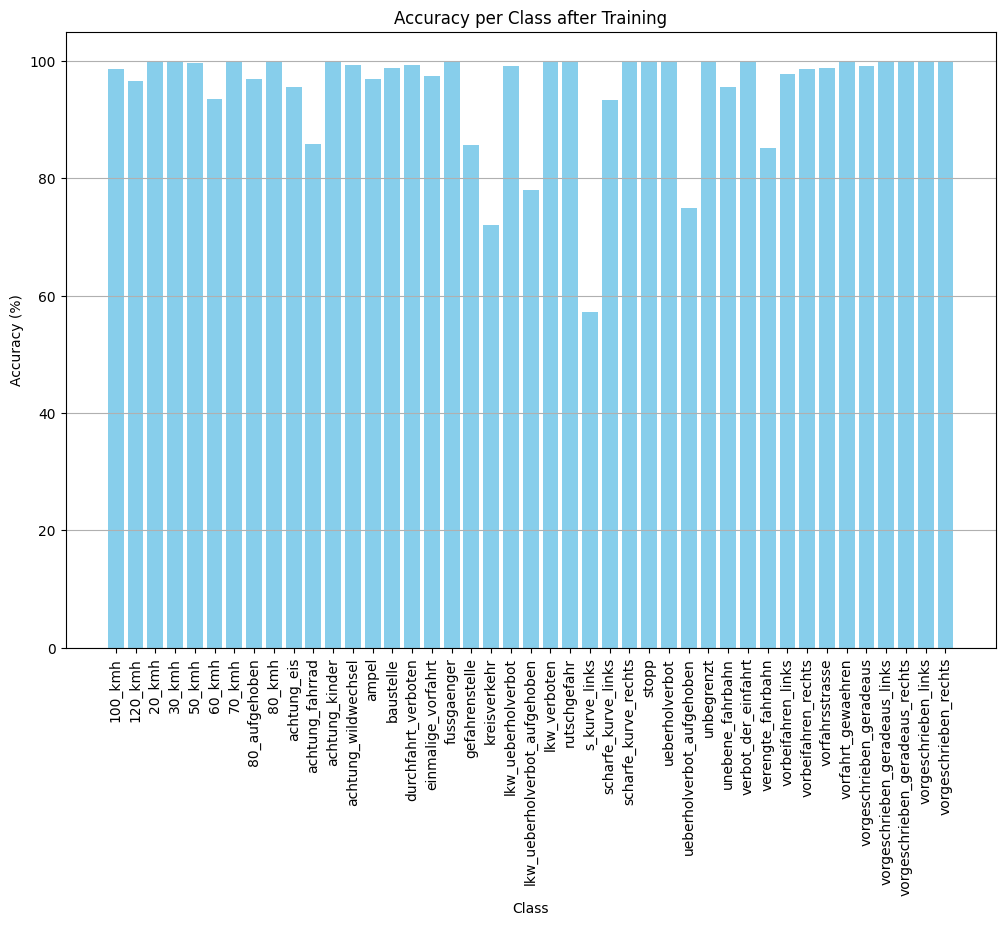

In [36]:
import torch
import matplotlib.pyplot as plt

# Berechnet die Accuracy pro Klasse, ohne die Anzahl der Klassen als Eingabe zu benötigen
def calculate_class_accuracy(model, data_loader, device):
    model.eval()
    
    # Hole die Anzahl der Klassen und die Klassennamen aus dem Dataset
    class_names = data_loader.dataset.classes
    num_classes = len(class_names)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Sammle die Richtigkeit der Vorhersagen für jede Klasse
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1
    
    # Berechne die Accuracy für jede Klasse
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy, class_names

# Berechne und plotte die Klassenaccuracy nach den 40 Trainingsepochen
class_accuracies, class_names = calculate_class_accuracy(model, test_loader, device)

# Plot Histogramm der Klassenaccuracies mit Klassennamen auf der x-Achse
plt.figure(figsize=(12, 8))
plt.bar(range(len(class_names)), class_accuracies, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Class after Training')
plt.xticks(range(len(class_names)), class_names, rotation=90)  # Setzt die Klassennamen als x-Achsen-Beschriftungen
plt.grid(axis='y')
plt.show()


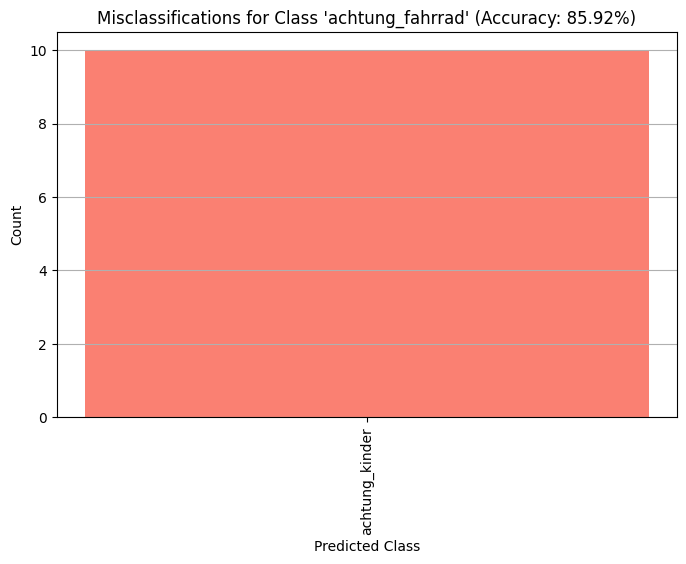

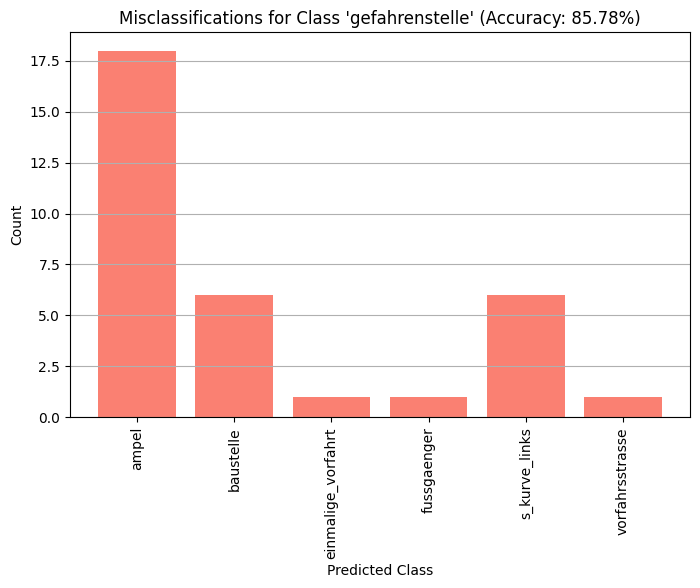

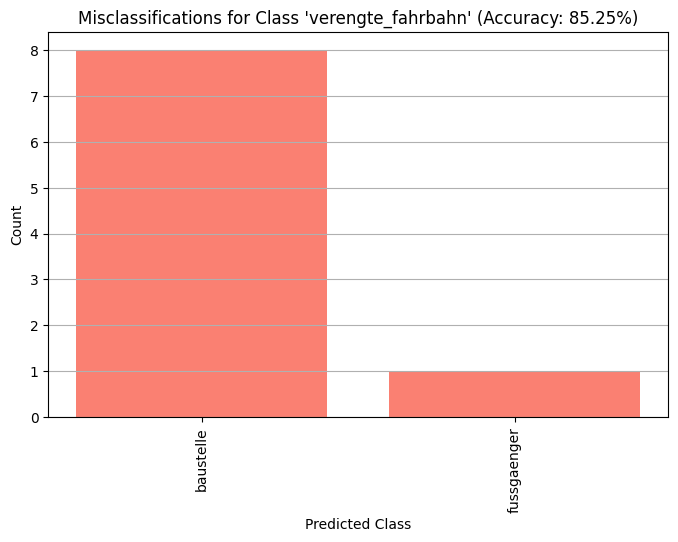

In [ ]:
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

# Berechnet die Accuracy pro Klasse und speichert falsche Vorhersagen
def calculate_class_accuracy_and_misclassifications(model, data_loader, device):
    model.eval()
    
    # Hole die Anzahl der Klassen und die Klassennamen aus dem Dataset
    class_names = data_loader.dataset.classes
    num_classes = len(class_names)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    misclassified_counts = defaultdict(lambda: [0] * num_classes)  # Zählt Fehlklassifizierungen je Klasse
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Zählt korrekte und fehlerhafte Vorhersagen
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1
                else:
                    misclassified_counts[label][predicted[i].item()] += 1  # Fehlklassifizierung speichern
    
    # Berechne die Accuracy für jede Klasse
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy, class_names, misclassified_counts

# Berechne Accuracy und Fehlklassifizierungen
class_accuracies, class_names, misclassified_counts = calculate_class_accuracy_and_misclassifications(model, test_loader, device)

# Erstelle Plots für Klassen mit einer Accuracy < 80%
for i, accuracy in enumerate(class_accuracies):
    if accuracy < 90:
        # Bereite Daten für die Fehlklassifizierungen dieser Klasse auf
        misclassified_counts_for_class = misclassified_counts[i]
        misclassified_class_names = [class_names[j] for j in range(len(misclassified_counts_for_class)) if misclassified_counts_for_class[j] > 0]
        misclassified_class_counts = [misclassified_counts_for_class[j] for j in range(len(misclassified_counts_for_class)) if misclassified_counts_for_class[j] > 0]
        
        # Plot der Fehlklassifizierungen für die Klasse
        plt.figure(figsize=(8, 5))
        plt.bar(misclassified_class_names, misclassified_class_counts, color='salmon')
        plt.xlabel('Predicted Class')
        plt.ylabel('Count')
        plt.title(f"Misclassifications for Class '{class_names[i]}' (Accuracy: {accuracy:.2f}%)")
        plt.xticks(rotation=90)
        plt.grid(axis='y')
        plt.show()


#### If you want to test an old model, you can do this right here

Define the CNN Model Class vor Evaluation. Make sure you replace this with the correct Conv Layers and FC Layers of your trained model. 

In [28]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)
        
        
        self.fc6 = nn.Linear(128, 512) 
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()


        self.fc9 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = out.reshape(out.size(0), -1)
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)

        out = self.fc9(out)

        return out

Provide now informations such as path and the number of output classes

In [29]:
model_path = 'model/base_sgd_model.pth'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Das Modell unter '{model_path}' wurde nicht gefunden.")

# Modell laden
trained_model = Net(num_classes=43)
trained_model.load_state_dict(torch.load(model_path))

C:\Users\v814u63\AppData\Local\Temp\ipykernel_24512\982607895.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

Now you can test your new model

In [31]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Determine the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the same device
trained_model.to(device)
# Calculate accuracy on training data
train_accuracy = calculate_accuracy(trained_model, train_loader, device)
print(f"Accuracy on training data: {train_accuracy:.2f}%")

# Calculate accuracy on test data
test_accuracy = calculate_accuracy(trained_model, test_loader, device)
print(f"Accuracy on test data: {test_accuracy:.2f}%")

Accuracy on training data: 98.35%
Accuracy on test data: 93.46%
